In [2]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pyfits
execfile("/Users/azuri/entwicklung/python/myUtils.py")# import getDate, findClosestDate

%matplotlib inline

starPosCCD = [1048+256,1024]

def countObjectColumns(areas):
    nCols = 0
    for area in areas:
        nCols += area[1]-area[0]
    return nCols

def findFirstIdxWithValGT(valueArr, val):
    idx = 0
    while valueArr[idx] < val:
        idx += 1
    return idx

def populateSkyArray(imageData, area):
    sky = np.copy(imageData[:,area[0]:area[1]])
    return sky

def populateObjectArray(imageData, areas):
    nCols = countObjectColumns(areas)
    print 'nCols = ',nCols
    obsCols = np.zeros(shape=(imageData.shape[0],nCols), dtype=type(imageData[0,0]))
    nCols = 0
    for area in areas:
#        print 'imageData[1000,',area[0],':',area[1],'] = ',imageData[1000,area[0]:area[1]]
        obsCols[:,nCols:nCols+area[1]-area[0]] = np.copy(imageData[:,area[0]:area[1]])
        nCols += area[1]-area[0]
    return obsCols

# --- fit y = a*x + b
# --- return value w: w[0] = a, w[1] = b
def linReg(x,y):
    oneD = False
    if (len(y.shape) < 2):
        oneD = True
    A = np.array([ x, np.ones(len(x))])
#    print 'linReg: A = ',A
#    print 'linReg: A.T = ',A.T
#    print 'linReg: x.shape = ',x.shape,', A.shape = ',A.shape,', y.shape = ',y.shape
    if not oneD:
        w = []
        for iy in range(y.shape[0]):
            w.append(np.linalg.lstsq(A.T,y[iy,:])[0])
    #        print 'linReg: iy = ',iy,': w[',iy,'] = ',w[iy]
    else:
#        print 'A.shape = ',A.shape
#        print 'y.shape = ',y.shape
        w = np.linalg.lstsq(A.T,y)[0]
    return w

# axis: 0 (columns) or 1 (rows)
# width: odd number
def boxCarMedianSmooth(imageData, axis, width):
    newDataArray = np.zeros(shape=imageData.shape, dtype=type(imageData[0,0]))
    if axis == 0:
        for iRow in range(imageData.shape[0]):
            for iCol in range(imageData.shape[1]):
                if iCol < int(width/2.0):
                    iColStart = 0
                    iColEnd = iCol+int(width/2.0)+1
                elif iCol > imageData.shape[1]-int(width/2.0)-1:
                    iColStart = iCol - int(width/2.0)
                    iColEnd = imageData.shape[1]
                else:
                    iColStart = iCol - int(width/2.0)
                    iColEnd = iCol + int(width/2.0) + 1
                newDataArray[iRow,iCol] = np.median(imageData[iRow,iColStart:iColEnd])
#                print 'iRow = ',iRow,', iCol = ',iCol,': iColStart = ',iColStart,', iColEnd = ',iColEnd,': imageData[iRow,iColStart:iColEnd] = ',imageData[iRow,iColStart:iColEnd],': median = ',newDataArray[iRow,iCol]
    elif axis == 1:
        for iCol in range(imageData.shape[1]):
            for iRow in range(imageData.shape[0]):
                if iRow < int(width/2.0):
                    iRowStart = 0
                    iRowEnd = iRow+int(width/2.0)+1
                elif iRow > imageData.shape[0]-int(width/2.0)-1:
                    iRowStart = iRow - int(width/2.0)
                    iRowEnd = imageData.shape[1]
                else:
                    iRowStart = iRow - int(width/2.0)
                    iRowEnd = iRow + int(width/2.0) + 1
                newDataArray[iRow,iCol] = np.median(imageData[iRowStart:iRowEnd,iCol])
#                print 'iCol = ',iCol,', iRow = ',iRow,': iRowStart = ',iRowStart,', iRowEnd = ',iRowEnd,': imageData[iRowStart:iRowEnd,iCol] = ',imageData[iRowStart:iRowEnd,iCol],': median = ',newDataArray[iRow,iCol]
    else:
        print 'ERROR: axis(=',axis,') out of bounds [0,1]'
    return newDataArray

# --- in case of 1D image data replace the area [skyLeftArea[1]:skyRightArea[0]] with the interpolated 'sky'
# --- otherwise subtract the 2D sky image from the 2D image data
def subtractSky(imageData,skyLeftArea,skyRightArea):
    dtype = None
    axis = None
    oneD = False
    if (len(imageData.shape) > 1):
        dtype = type(imageData[0,0])
        axis = 1
    else:
        dtype = type(imageData[0])
        oneD = True
        axis = 0
#    print 'oneD = ',oneD
    newImageData = np.ndarray(imageData.shape, dtype=dtype)
    skyData = np.ndarray(imageData.shape, dtype=dtype)
    xSky = np.concatenate([np.arange(skyLeftArea[0],skyLeftArea[1],1.0),np.arange(skyRightArea[0],skyRightArea[1],1.0)])
#    print 'subtractSky: xSky = ',xSky
    if (oneD):
        ySky = np.concatenate([imageData[skyLeftArea[0]:skyLeftArea[1]], imageData[skyRightArea[0]:skyRightArea[1]]])
    else:
        ySky = np.concatenate([populateSkyArray(imageData, skyLeftArea), populateSkyArray(imageData, skyRightArea)],axis=1)
#    print 'subtractSky ySky = ',len(ySky),': ',ySky
#    print 'xSky.shape = ',xSky.shape
#    print 'ySky.shape = ',ySky.shape
    skyParams = linReg(xSky,ySky)
#    print 'type(skyParams) = ',type(skyParams)
#    print 'subtractSky: imageData.shape = ',imageData.shape,', newImageData.shape = ',newImageData.shape,', xSky.shape = ',xSky.shape,', len(skyParams) = ',len(skyParams),', len(skyParams[0]) = ',len(skyParams[0])
    xObs = np.arange(0.0,imageData.shape[axis],1.0,dtype=dtype)
#    print 'subtractSky: xObs = ',xObs.shape,': ',xObs
    if oneD:
        skyData[:] = (skyParams[0] * xObs) + skyParams[1]
        newImageData[:] = imageData[:]
        newImageData[skyLeftArea[1]:skyRightArea[0]] = skyData[skyLeftArea[1]:skyRightArea[0]]
    else:
        for iRow in range(imageData.shape[0]):
    #        print 'subtractSky: imageData[',iRow,',:] = ',imageData[iRow,:],', newImageData[',iRow,',:].shape = ',newImageData[iRow,:].shape,', skyParams[',iRow,'] = ',len(skyParams[iRow]),': ',skyParams[iRow]
            skyData[iRow,:] = (skyParams[iRow][0] * xObs) + skyParams[iRow][1]
    #        print 'subtractSky: skyData[',iRow,',:] = ',skyData[iRow,:]
            newImageData[iRow,:] = imageData[iRow,:] - skyData[iRow,:]
    #        print 'subtractSky: newImageData[',iRow,',:] = ',newImageData[iRow,:]
    return [newImageData,skyData]

#def subtractSky(obsAreas,obsData,skyLeftArea,skyLeft,skyRightArea,skyRight):
#    newObsData = np.ndarray(obsData.shape, dtype=type(obsData[0,0]))
##    xSkyLeft = np.arange(skyLeftArea[0],skyLeftArea[1],1.0)
##    xSkyRight = np.arange(skyRightArea[0],skyRightArea[1],1.0)
#    xSky = np.concatenate([np.arange(skyLeftArea[0],skyLeftArea[1],1.0),np.arange(skyRightArea[0],skyRightArea[1],1.0)])
#    print 'subtractSky: xSky = ',xSky
#    nCols = 0
#    for area in obsAreas:
#        nCols += area[1]-area[0]
#    print 'subtractSky: nCols = ',nCols
#
#    xObs = np.ndarray(nCols, dtype=type(obsData[0,0]))
#    nCols = 0
#    for area in obsAreas:
#        xObs[nCols:nCols+area[1]-area[0]] = np.arange(area[0],area[1],1.0)
#        print 'subtractSky: area = ',area,': nCols = ',nCols,': xObs[',nCols,':',nCols+area[1]-area[0],'] = ',xObs[nCols:nCols+area[1]-area[0]]
#        nCols += area[1]-area[0]
#    print 'subtractSky: nCols = ',nCols
#    ySky = np.concatenate([skyLeft, skyRight],axis=1)
#    print 'subtractSky = ',len(ySky),': ',ySky
#    skyParams = linReg(xSky,ySky)
#    print 'type(skyParams) = ',type(skyParams)
#    print 'subtractSky: obsData.shape = ',obsData.shape,', newObsData.shape = ',newObsData.shape,', xObs.shape = ',xObs.shape,', len(skyParams) = ',len(skyParams),', len(skyParams[0]) = ',len(skyParams[0])
#    for iRow in range(obsData.shape[0]):
#        print 'subtractSky: obsData.shape = ',obsData.shape,', newObsData.shape = ',newObsData.shape,', obsData[',iRow,',:].shape = ',obsData[iRow,:].shape,', xObs.shape = ',xObs.shape,', len(skyParams) = ',len(skyParams)
#        newObsData[iRow,:] = obsData[iRow,:] - ((skyParams[iRow][1] * xObs) + skyParams[iRow][0])
#        print 'subtractSky: newObsData[',iRow,',:] = ',newObsData[iRow,:]
#    STOP
#    return newObsData

def getWavelength(header):
    nPix = int(header['NAXIS2'])
    crPix = int(header['CRPIX2'])
    crVal = float(header['CRVAL2'])
    cDelt = float(header['CDELT2'])
    lam = np.arange(crVal, crVal + (nPix*cDelt), cDelt, dtype=np.float32)
#    print 'getWavelength: lam = ',len(lam),': ',lam
    return lam

def markAreas(imageData, skyAreaLeft, skyAreaRight, objectAreas):
    maxImageData = np.amax(imageData)
    minImageData = np.amin(imageData)
    imageData[:,skyAreaLeft[0]] = minImageData
    imageData[:,skyAreaLeft[1]] = minImageData
    imageData[:,skyAreaRight[0]] = minImageData
    imageData[:,skyAreaRight[1]] = minImageData
    for area in objectAreas:
        imageData[:,area[0]] = maxImageData
        imageData[:,area[1]] = maxImageData



airmass =  1.300327
{'SkyLeft': [835, 960], 'ObjectAreas': [[1262, 1330], [1157, 1240]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1570, 1760], 'ylim': [0, 0], 'OName': 'IPHASXJ194645'}


/Users/azuri/anaconda/envs/python2env/lib/python2.7/site-packages/ipykernel_launcher.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


nCols =  151


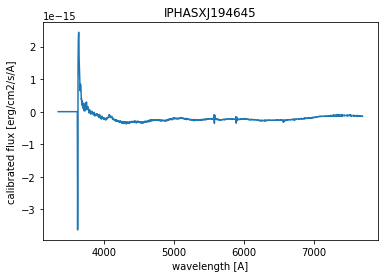

/Users/azuri/anaconda/envs/python2env/lib/python2.7/site-packages/ipykernel_launcher.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


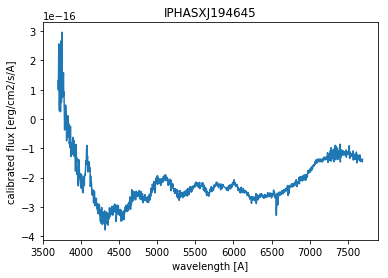

time =  2017-04-17 04:07:02
datestr = <170417>
airmass =  1.272968
{'SkyLeft': [1094, 1166], 'ObjectAreas': [[1200, 1228], [1251, 1306], [1321, 1340], [1358, 1407], [1425, 1450]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1474, 1588], 'ylim': [-3e-16, 1.3e-15], 'OName': 'Kn19'}
nCols =  176


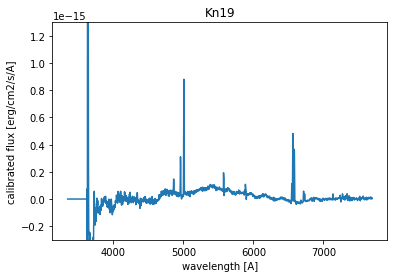

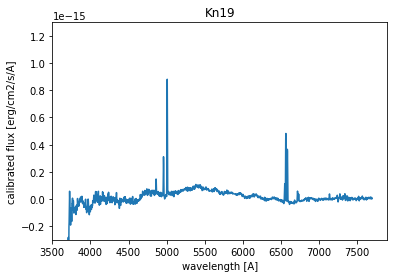

time =  2017-04-17 04:57:22
datestr = <170417>
airmass =  1.08889
{'SkyLeft': [1104, 1228], 'ObjectAreas': [[1238, 1296]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1320, 1435], 'ylim': [-1e-16, 2e-16], 'OName': 'Kn45'}
nCols =  58


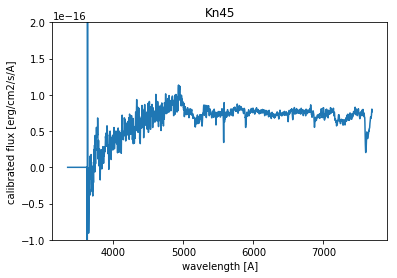

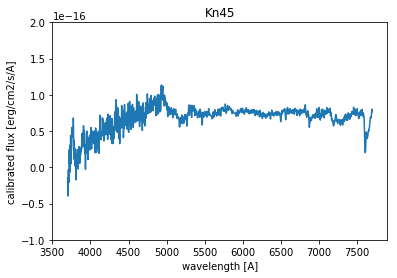

time =  2017-05-18 04:34:00
datestr = <180517>
airmass =  1.127338
{'SkyLeft': [889, 991], 'ObjectAreas': [[1090, 1256], [1326, 1540]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1546, 1608], 'ylim': [0, 0], 'OName': 'DSHJ205811'}
nCols =  380


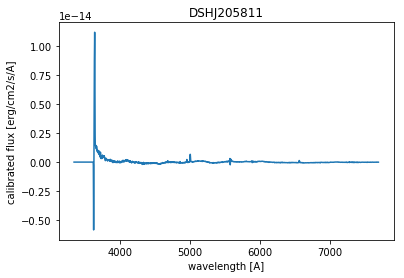

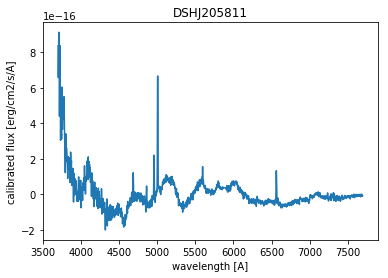

time =  2017-08-12 02:55:06
datestr = <120817>
airmass =  1.867151
{'SkyLeft': [680, 780], 'ObjectAreas': [[1090, 1292], [1334, 1380], [1404, 1429], [1479, 1506], [1538, 1554]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1626, 1704], 'ylim': [-2e-15, 2e-15], 'OName': 'DSHJ221013'}
nCols =  316


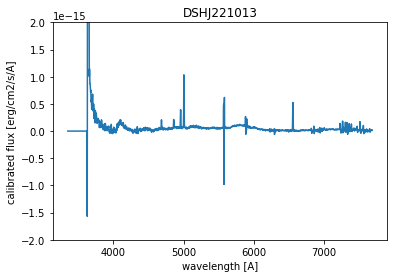

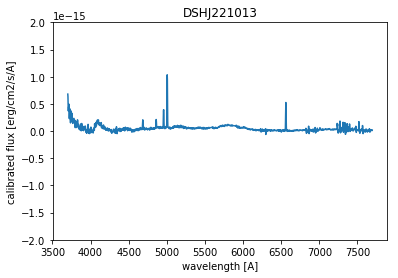

time =  2017-05-18 02:36:13
datestr = <180517>
airmass =  1.143896
{'SkyLeft': [1092, 1276], 'ObjectAreas': [[1300, 1396]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1544, 1756], 'ylim': [-3e-16, 1.5e-16], 'OName': 'IPHASXJ194745'}
nCols =  96


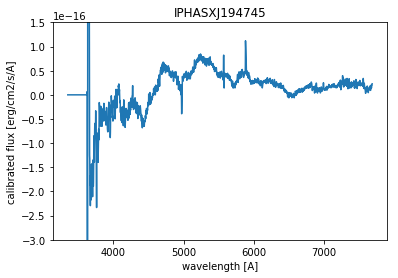

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0006/gtc_object_av_wl_flt_cal_mSky_obs_smoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


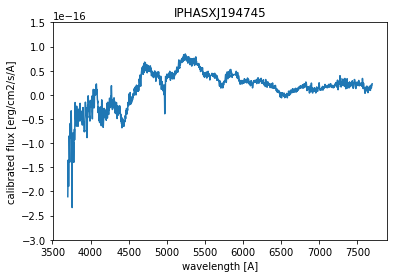

time =  2017-04-16 04:59:27
datestr = <160417>
airmass =  1.237779
{'SkyLeft': [944, 1028], 'ObjectAreas': [[1133, 1150], [1189, 1226], [1241, 1300], [1318, 1331], [1342, 1389], [1407, 1432], [1445, 1468], [1494, 1502]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1536, 1608], 'ylim': [-5e-16, 1e-15], 'OName': 'Ou3'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ194745_GT160417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  229


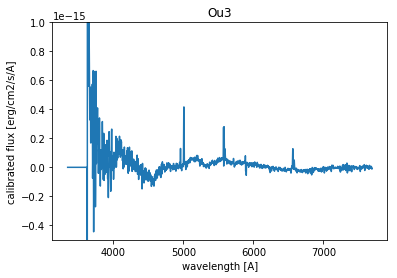

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

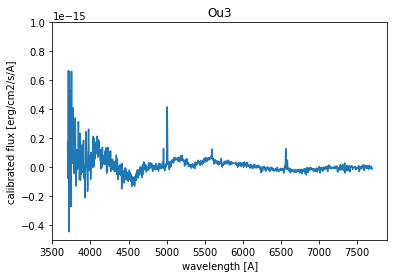

time =  2017-04-14 04:29:42
datestr = <140417>
airmass =  1.217525
{'SkyLeft': [700, 850], 'ObjectAreas': [[916, 1038], [1090, 1180], [1198, 1303], [1320, 1556], [1566, 1700]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1700, 1812], 'ylim': [-2e-15, 4e-15], 'OName': 'Kn24'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Ou3_GT140417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  687


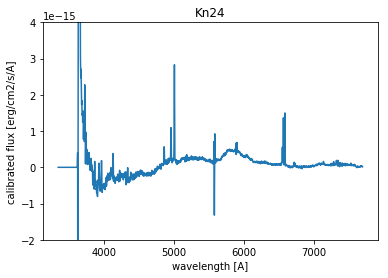

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

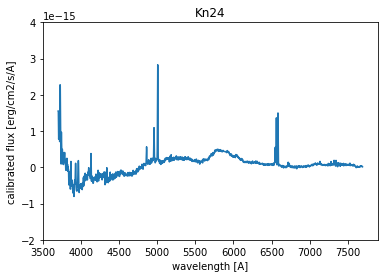

time =  2017-08-12 03:45:36
datestr = <120817>


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn24_GT120817.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


airmass =  1.179397
{'SkyLeft': [440, 570], 'ObjectAreas': [[1106, 1134], [1150, 1194], [1254, 1320], [1338, 1348], [1496, 1594]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1837, 1918], 'ylim': [-3e-16, 7e-16], 'OName': 'LDu1'}
nCols =  246


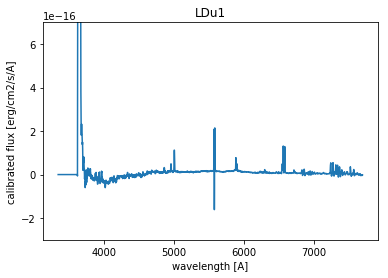

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

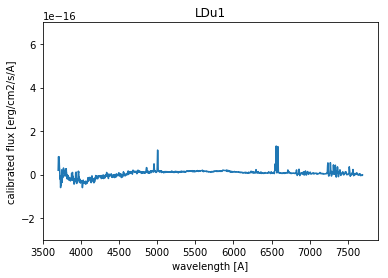

time =  2017-05-26 04:18:33
datestr = <260517>
airmass =  1.421841
{'SkyLeft': [1231, 1288], 'ObjectAreas': [[1293, 1307], [1320, 1331]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1423, 1479], 'ylim': [-1e-16, 5e-16], 'OName': 'IPHASXJ193617'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/LDu1_GT260517.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  25


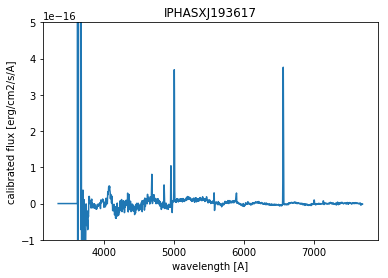

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

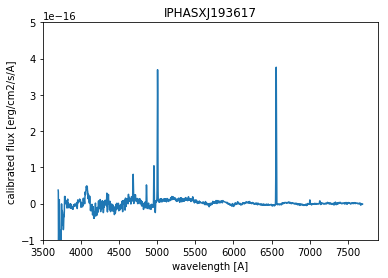

time =  2017-04-12 03:48:56
datestr = <120417>
airmass =  1.26845
{'SkyLeft': [1090, 1185], 'ObjectAreas': [[1248, 1273], [1287, 1306], [1323, 1350], [1365, 1374]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1444, 1555], 'ylim': [-2e-16, 5e-16], 'OName': 'IPHASXJ194728'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ193617_GT120417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  80


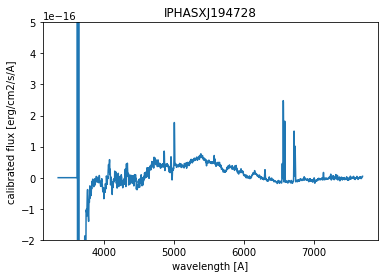

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

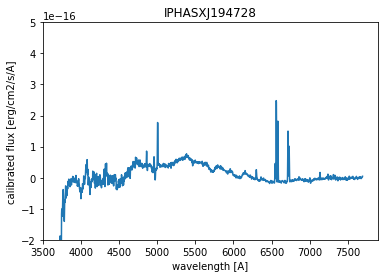

time =  2017-04-12 04:39:37
datestr = <120417>
airmass =  1.221761
{'SkyLeft': [1139, 1248], 'ObjectAreas': [[1272, 1325]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1382, 1513], 'ylim': [-3e-15, 8e-15], 'OName': 'IPHASXJ194301'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ194728_GT120417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  53


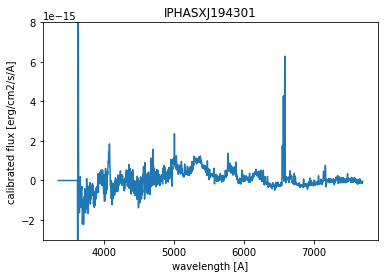

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

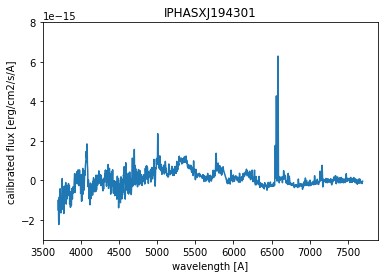

time =  2017-04-15 04:37:43
datestr = <150417>
airmass =  1.100612
{'SkyLeft': [1090, 1222], 'ObjectAreas': [[1284, 1304], [1324, 1348]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1357, 1475], 'ylim': [-3e-16, 5e-16], 'OName': 'IPHASXJ194301'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ194301_GT150417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  44


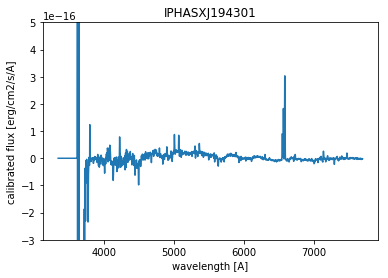

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting exis

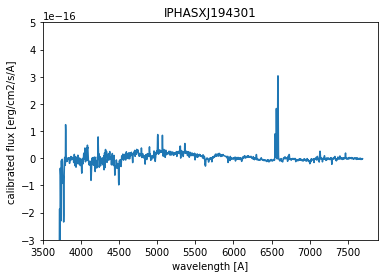

time =  2017-04-12 05:37:04
datestr = <120417>
airmass =  1.280201
{'SkyLeft': [1090, 1177], 'ObjectAreas': [[1299, 1350]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1376, 1449], 'ylim': [0, 0], 'OName': 'PNG124.1-01.9'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ194301_GT120417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  51


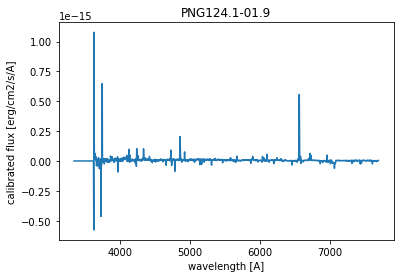

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

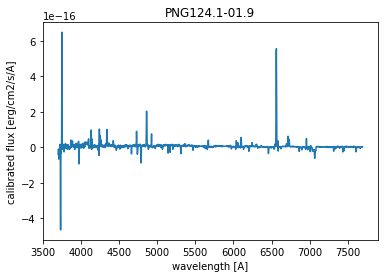

time =  2017-09-13 04:54:07
datestr = <130917>
airmass =  1.24472
{'SkyLeft': [682, 816], 'ObjectAreas': [[864, 953], [968, 1038], [1091, 1126], [1138, 1303], [1318, 1424], [1440, 1558], [1564, 1595], [1612, 1680], [1703, 1720], [1759, 1902]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1930, 2013], 'ylim': [-2e-15, 8e-15], 'OName': 'IPHASXJ014238+600947'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/PNG124.1-01.9_GT130917.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  842


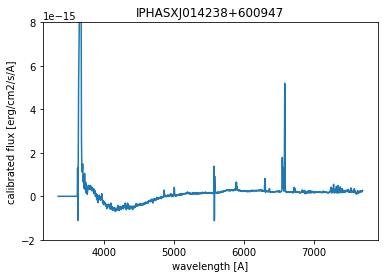

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

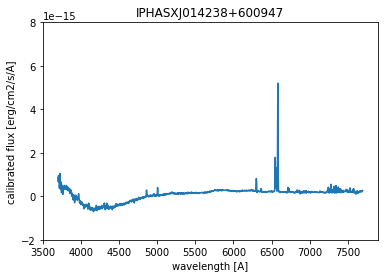

time =  2017-09-13 05:17:32
datestr = <130917>
airmass =  1.25605
{'SkyLeft': [170, 324], 'ObjectAreas': [[363, 457], [478, 542], [559, 576], [594, 726], [743, 786], [834, 855], [872, 897], [910, 1038], [1090, 1194], [1221, 1273], [1328, 1436], [1505, 1560], [1596, 1760], [1785, 1850], [1877, 1909], [1928, 1950]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1961, 2024], 'ylim': [0, 0], 'OName': 'IPHASXJ031058.8+624755'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ014238+600947_GT130917.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  1126


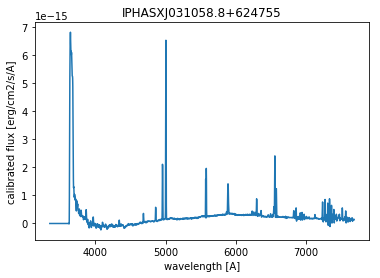

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

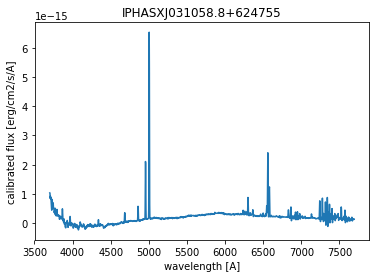

time =  2017-09-30 05:21:33
datestr = <300917>
airmass =  1.083561
{'SkyLeft': [231, 522], 'ObjectAreas': [[1197, 1303], [1320, 1450]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1842, 2010], 'ylim': [-1e-15, 1.5e-15], 'OName': 'IPHASXj040721.5+512422'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ031058.8+624755_GT300917.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  236


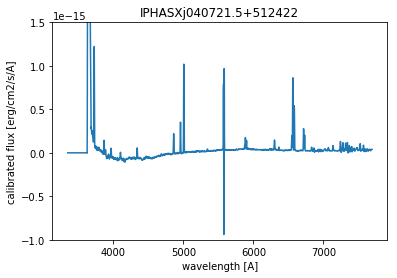

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

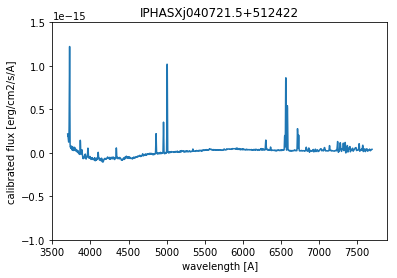

time =  2017-09-21 05:19:28
datestr = <210917>
airmass =  1.00319
{'SkyLeft': [167, 380], 'ObjectAreas': [[701, 1035], [1124, 1154], [1171, 1300], [1325, 1555], [1607, 1880]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1872, 2025], 'ylim': [-2e-14, 1e-14], 'OName': 'IPHASXJ051152.2+302751'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXj040721.5+512422_GT210917.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  996


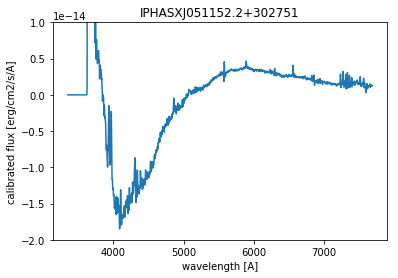

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

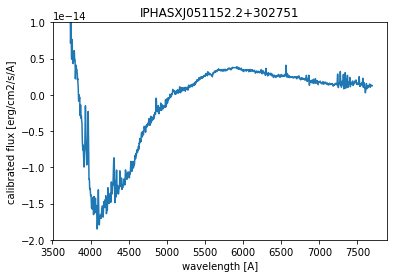

time =  2017-12-06 01:44:16
datestr = <061217>
airmass =  1.036974
{'SkyLeft': [300, 556], 'ObjectAreas': [[1201, 1300], [1320, 1474]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1778, 1923], 'ylim': [-1.5e-15, 1e-15], 'OName': 'IPHASXJ053650.8+245616'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ051152.2+302751_GT061217.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  253


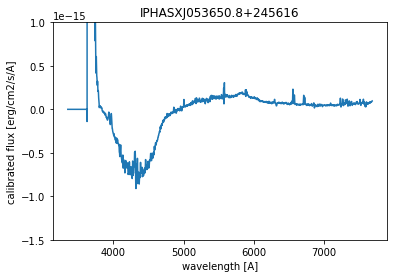

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

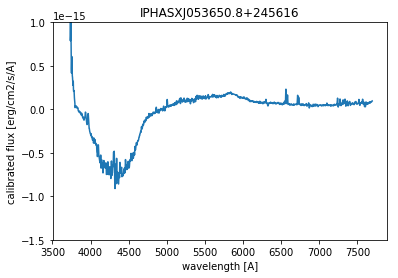

time =  2017-12-07 00:38:56
datestr = <071217>
airmass =  1.041772
{'SkyLeft': [1090, 1248], 'ObjectAreas': [[1265, 1294], [1327, 1466]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1675, 1957], 'ylim': [-2e-15, 1.5e-14], 'OName': 'IPHASXJ055242.8+262116'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ053650.8+245616_GT071217.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  168


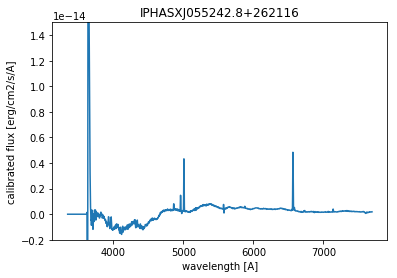

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

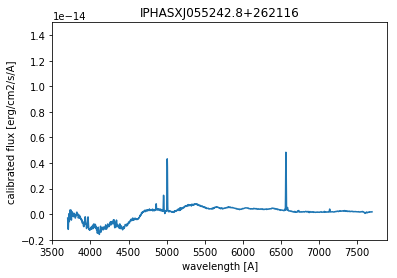

time =  2018-01-03 01:28:00
datestr = <030118>
airmass =  1.149267
{'SkyLeft': [622, 808], 'ObjectAreas': [[1491, 1537]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1771, 1971], 'ylim': [-2e-16, 1.5e-16], 'OName': 'IPHASXJ185322.1+083018'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ055242.8+262116_GT030118.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  46


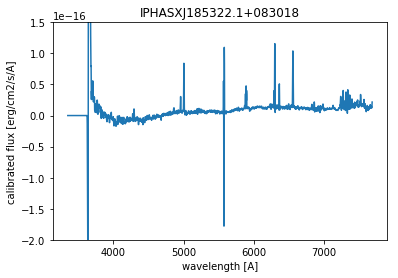

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

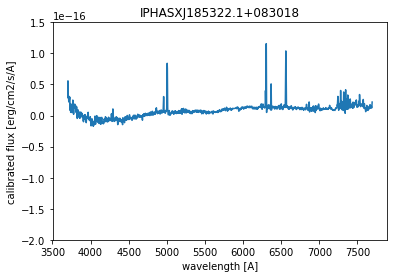

time =  2017-09-24 21:22:21
datestr = <240917>
airmass =  1.34775
{'SkyLeft': [423, 468], 'ObjectAreas': [[846, 870], [882, 977], [985, 1002], [1011, 1038], [1132, 1183], [1196, 1223], [1245, 1304], [1346, 1390], [1519, 1534], [1565, 1626], [1635, 1696], [1714, 1746], [1758, 1806]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1836, 1878], 'ylim': [-5e-15, 5e-15], 'OName': 'IPHASXJ191306.1+025248'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ185322.1+083018_GT240917.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  561


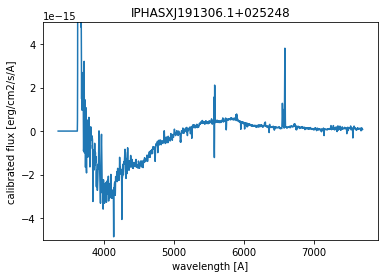

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

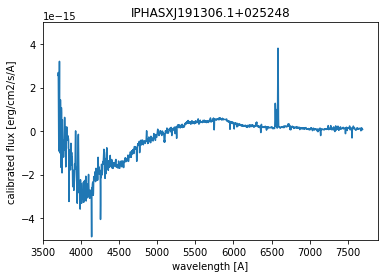

time =  2017-10-03 21:54:56
datestr = <031017>
airmass =  1.037058
{'SkyLeft': [325, 513], 'ObjectAreas': [[888, 958], [1101, 1152], [1180, 1210], [1245, 1299], [1309, 1350], [1368, 1399], [1425, 1478], [1491, 1560]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1936, 2021], 'ylim': [-1e-15, 1.2e-15], 'OName': 'SNR060707'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ191306.1+025248_GT031017.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  399


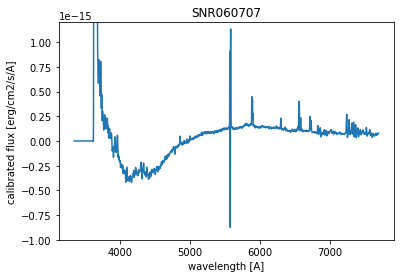

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

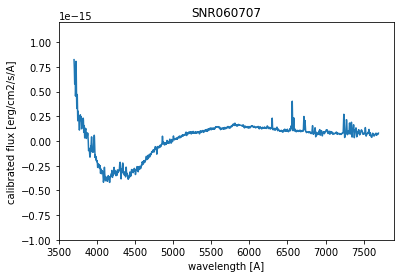

time =  2017-12-10 03:14:19
datestr = <101217>
airmass =  1.004278
{'SkyLeft': [517, 800], 'ObjectAreas': [[1256, 1300], [1325, 1388]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1718, 2004], 'ylim': [-2e-16, 5e-16], 'OName': 'SNR060715'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/SNR060707_GT101217.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  107


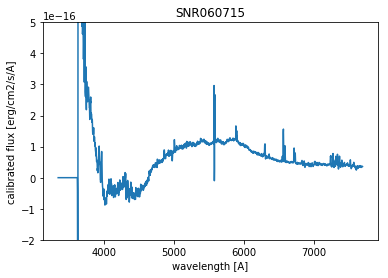

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

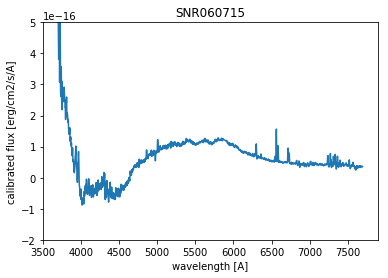

time =  2017-12-08 02:36:16
datestr = <081217>
airmass =  1.083117
{'SkyLeft': [744, 935], 'ObjectAreas': [[1126, 1242], [1258, 1348], [1408, 1555]], 'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1788, 1927], 'ylim': [-5e-16, 5e-16], 'OName': 'SNR060930'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/SNR060715_GT081217.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  353


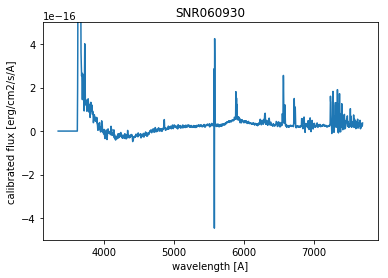

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

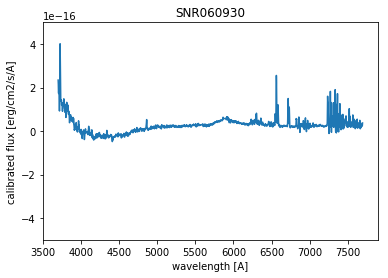

time =  2017-12-22 03:02:36
datestr = <221217>


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/SNR060930_GT221217.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


airmass =  1.50305
{'SkyLeft': [680, 920], 'ObjectAreas': [[1112, 1283], [1305, 1559]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1730, 2014], 'ylim': [0, 0], 'OName': 'KK26'}
nCols =  425


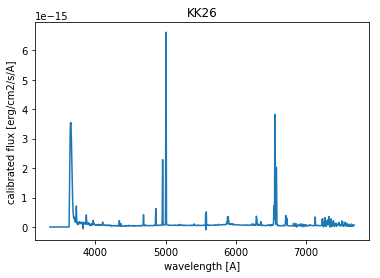

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

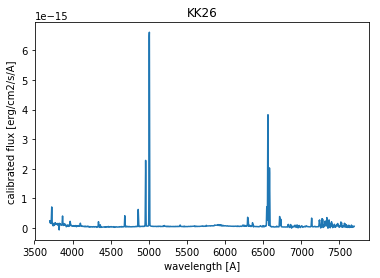

time =  2016-03-09 20:49:58
datestr = <090316>
airmass =  1.374651
{'SkyLeft': [800, 940], 'ObjectAreas': [[1163, 1183], [1218, 1234], [1270, 1295], [1325, 1357], [1394, 1443]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1468, 1565], 'ylim': [-2e-16, 5e-16], 'OName': 'Kn34'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/KK26_GT090316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  142


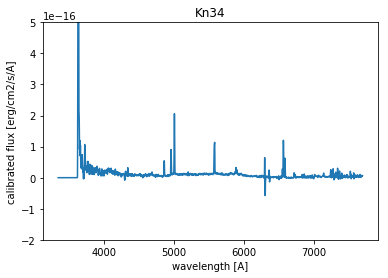

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

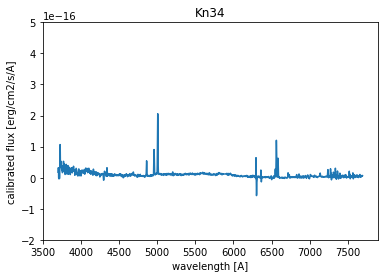

time =  2016-03-07 21:51:45
datestr = <070316>
airmass =  1.209659
{'SkyLeft': [368, 684], 'ObjectAreas': [[1090, 1327], [1361, 1456], [1470, 1513], [1522, 1529], [1543, 1561], [1564, 1625]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1926, 2025], 'ylim': [-1e-15, 1.2e-15], 'OName': 'CR1'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn34_GT070316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  461


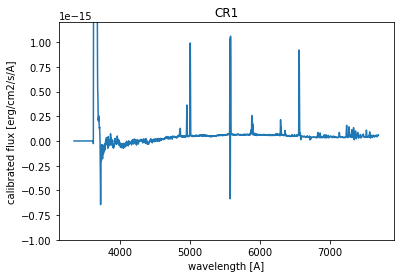

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

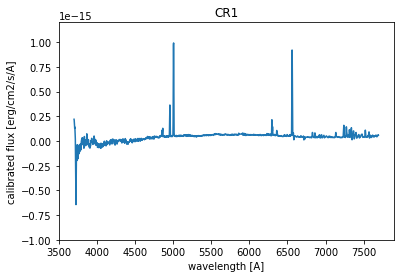

time =  2016-06-02 04:23:37
datestr = <020616>
airmass =  1.049193
{'SkyLeft': [1122, 1194], 'ObjectAreas': [[1278, 1302], [1318, 1340]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1427, 1532], 'ylim': [-1e-17, 5e-17], 'OName': 'Kn11'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/CR1_GT020616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  46


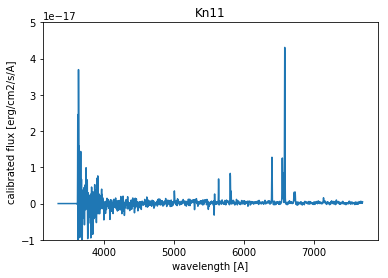

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

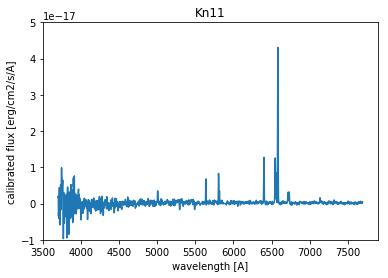

time =  2016-06-11 04:42:30
datestr = <110616>
airmass =  1.362657
{'SkyLeft': [643, 1017], 'ObjectAreas': [[1229, 1298], [1323, 1391]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1489, 1628], 'ylim': [0, 0], 'OName': 'HaWe3'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn11_GT110616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  137


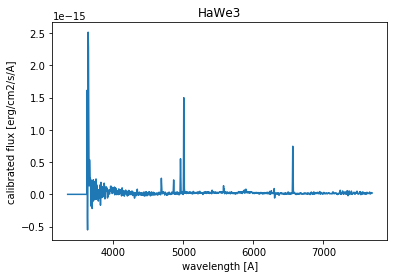

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

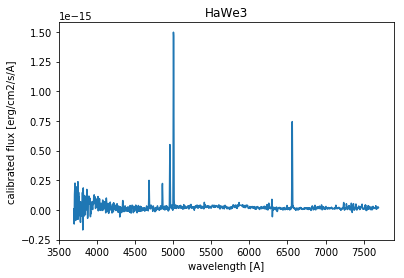

time =  2016-03-07 20:47:00
datestr = <070316>
airmass =  1.215667
{'SkyLeft': [770, 874], 'ObjectAreas': [[1216, 1253], [1265, 1301], [1321, 1332], [1348, 1389], [1410, 1420]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1442, 1570], 'ylim': [0, 0], 'OName': 'Kn48'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/HaWe3_GT070316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  135


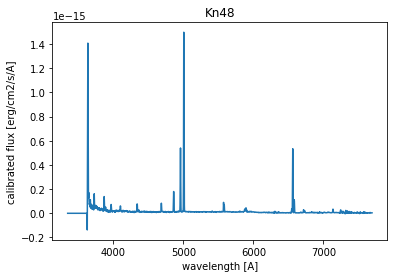

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

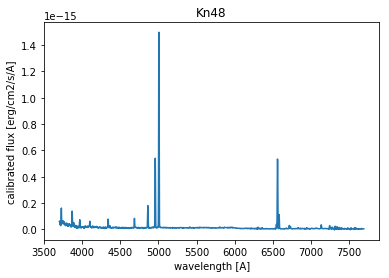

time =  2016-07-11 03:24:38
datestr = <110716>
airmass =  1.074739
{'SkyLeft': [1090, 1190], 'ObjectAreas': [[1195, 1300], [1324, 1337], [1358, 1430]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1526, 1700], 'ylim': [-2e-15, 9e-15], 'OName': 'Kn58'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn48_GT110716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  190


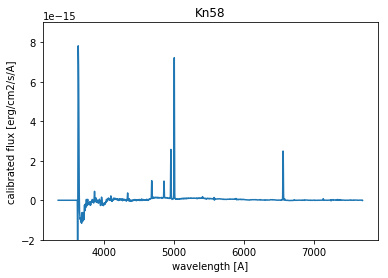

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

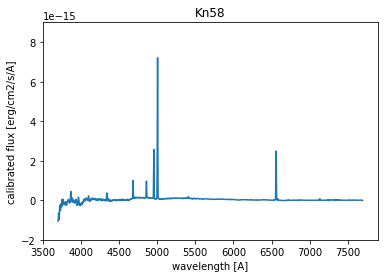

time =  2016-08-20 04:25:00
datestr = <200816>
airmass =  1.18847
{'SkyLeft': [852, 925], 'ObjectAreas': [[1133, 1346], [1405, 1443], [1460, 1475], [1494, 1507]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1528, 1604], 'ylim': [-2e-16, 1.9e-15], 'OName': 'Ou2'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn58_GT200816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  279


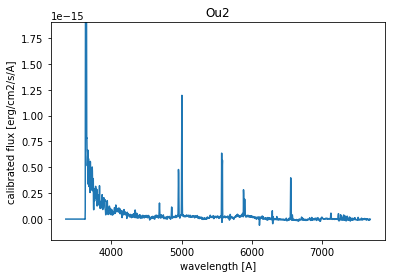

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

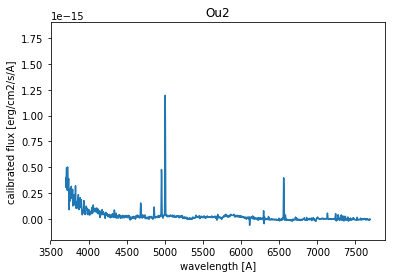

time =  2016-08-10 04:31:39
datestr = <100816>
airmass =  1.034825
{'SkyLeft': [1090, 1168], 'ObjectAreas': [[1188, 1305], [1317, 1368], [1379, 1397]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1432, 1477], 'ylim': [0, 0], 'OName': 'Abell68'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Ou2_GT100816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  186


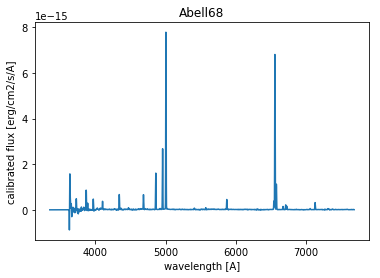

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

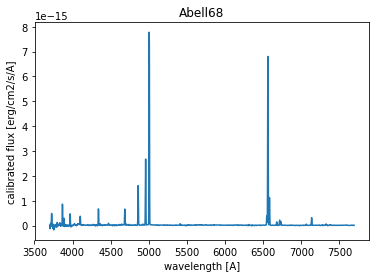

time =  2016-06-14 04:31:15
datestr = <140616>
airmass =  1.017599
{'SkyLeft': [747, 939], 'ObjectAreas': [[945, 998], [1013, 1036], [1090, 1241], [1254, 1303], [1338, 1400], [1453, 1558], [1581, 1763]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1893, 2020], 'ylim': [-5e-15, 5e-15], 'OName': 'Kn24'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Abell68_GT140616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  625


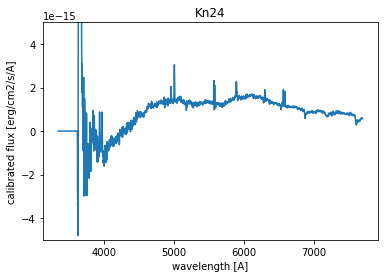

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

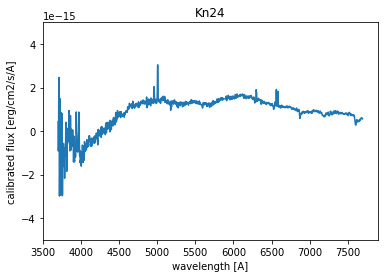

time =  2016-06-23 04:41:29
datestr = <230616>
airmass =  1.109938
{'SkyLeft': [612, 702], 'ObjectAreas': [[1090, 1122], [1164, 1212], [1241, 1252], [1268, 1282], [1307, 1353], [1367, 1407], [1435, 1445], [1495, 1516], [1530, 1556], [1602, 1650], [1670, 1700]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1823, 1855], 'ylim': [0, 0], 'OName': 'IPHASXJ190333_Green_Slit'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn24_GT230616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  326


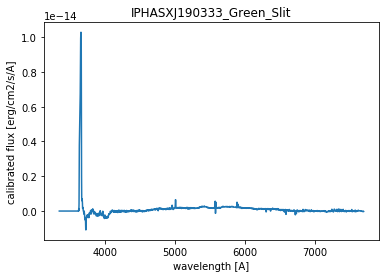

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

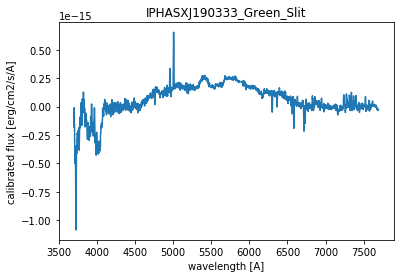

time =  2016-08-21 23:21:42
datestr = <210816>
airmass =  1.446888
{'SkyLeft': [314, 732], 'ObjectAreas': [[957, 1036], [1090, 1132], [1148, 1233], [1398, 1582]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1680, 1957], 'ylim': [-2.1e-15, 4e-15], 'OName': 'K1-6'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ190333_Green_Slit_GT210816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  390


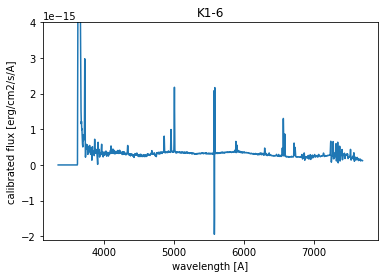

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

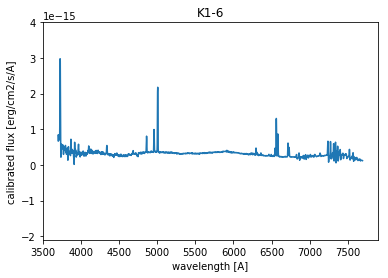

time =  2016-05-16 04:30:27
datestr = <160516>
airmass =  1.089785
{'SkyLeft': [407, 717], 'ObjectAreas': [[1090, 1166], [1182, 1226], [1238, 1304], [1315, 1350], [1395, 1452], [1465, 1480], [1492, 1550], [1564, 1573], [1588, 1642]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1847, 2020], 'ylim': [-6e-16, 1.8e-15], 'OName': 'LDu1'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/K1-6_GT160516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  414


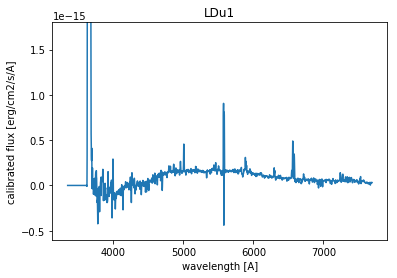

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

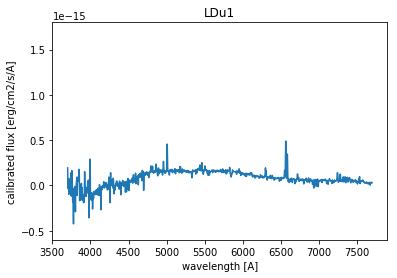

time =  2016-06-28 04:52:51
datestr = <280616>
airmass =  1.018462
{'SkyLeft': [1090, 1178], 'ObjectAreas': [[1259, 1337]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1438, 1505], 'ylim': [-5e-16, 2e-16], 'OName': 'IPHASXJ195627'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/LDu1_GT280616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  78


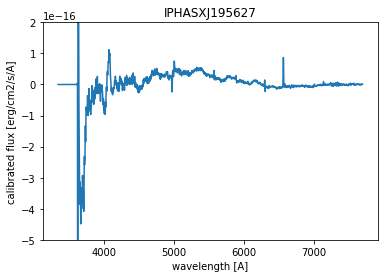

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

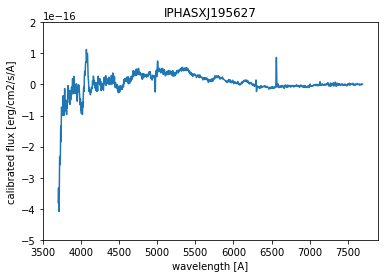

time =  2016-08-19 23:49:37
datestr = <190816>
airmass =  1.017609
{'SkyLeft': [1128, 1206], 'ObjectAreas': [[1290, 1299], [1325, 1329]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1681, 1780], 'ylim': [-2e-17, 2.7e-16], 'OName': 'IRAS20084'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ195627_GT190816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  13


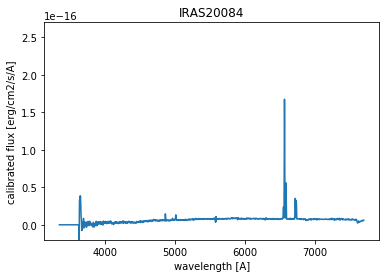

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

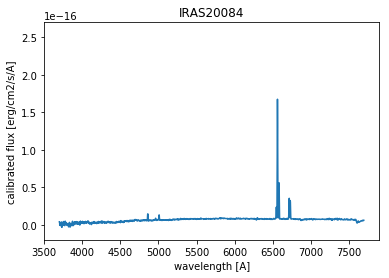

time =  2016-07-11 02:30:56
datestr = <110716>


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IRAS20084_GT110716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


airmass =  1.051185
{'SkyLeft': [637, 914], 'ObjectAreas': [[1213, 1266], [1288, 1340]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1671, 1781], 'ylim': [-5e-16, 7e-16], 'OName': 'IPHASXJ201058'}
nCols =  105


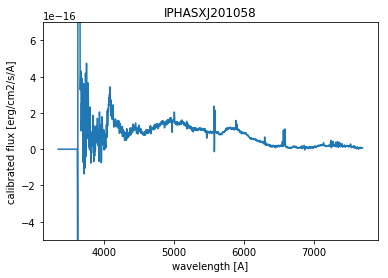

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

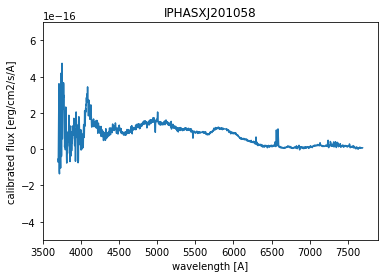

time =  2016-08-20 00:39:43
datestr = <200816>
airmass =  1.299646
{'SkyLeft': [366, 547], 'ObjectAreas': [[1188, 1300], [1345, 1361], [1398, 1420]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1884, 1940], 'ylim': [-5e-16, 2e-15], 'OName': 'Kn36'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ201058_GT200816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  150


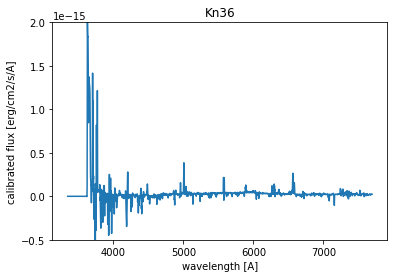

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

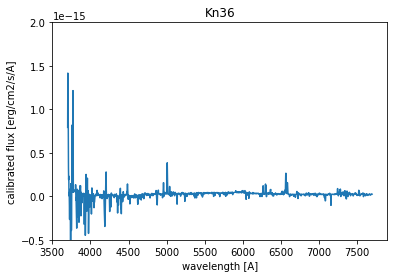

time =  2016-03-08 21:38:27
datestr = <080316>
airmass =  1.308502
{'SkyLeft': [404, 580], 'ObjectAreas': [[800, 957], [978, 1038], [1090, 1240], [1262, 1716]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1782, 1982], 'ylim': [0, 0], 'OName': 'We2-260'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn36_GT080316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  821


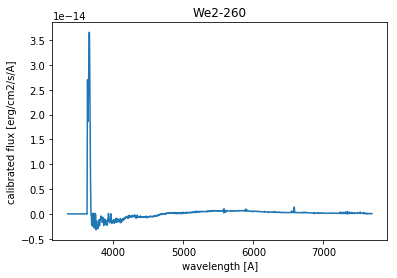

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

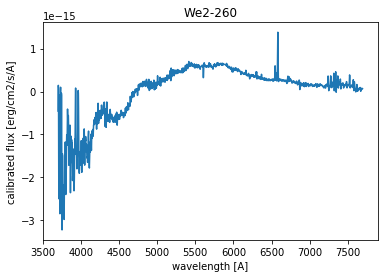

time =  2016-08-22 04:59:06
datestr = <220816>
airmass =  1.230004
{'SkyLeft': [536, 696], 'ObjectAreas': [[1192, 1232], [1269, 1432], [1311, 1359]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1571, 1659], 'ylim': [0, 0], 'OName': 'IPHASXJ225420'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/We2-260_GT220816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  251


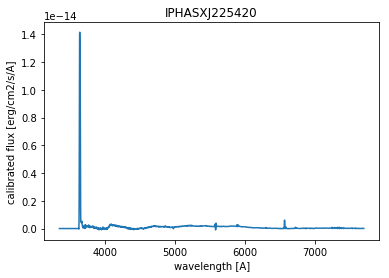

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

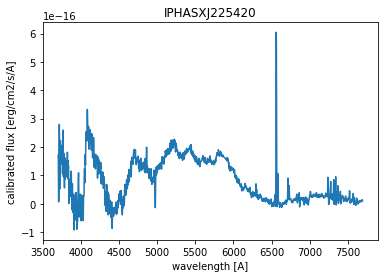

time =  2016-08-22 02:51:03
datestr = <220816>


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ225420_GT220816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


airmass =  1.01598
{'SkyLeft': [445, 489], 'ObjectAreas': [[1171, 1210], [1265, 1280], [1331, 1343], [1398, 1433]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1614, 1658], 'ylim': [0, 0], 'OName': 'Kn25'}
nCols =  101


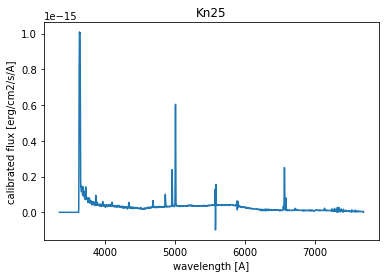

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

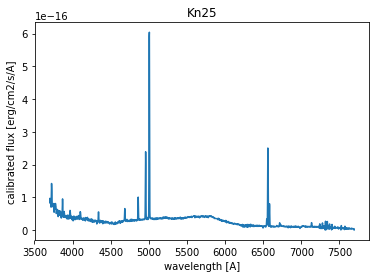

time =  2016-08-27 23:34:49
datestr = <270816>
airmass =  1.278222
{'SkyLeft': [369, 450], 'ObjectAreas': [[752, 839], [860, 978], [994, 1020], [1090, 1195], [1209, 1295], [1325, 1402], [1423, 1472], [1504, 1554], [1570, 1618], [1633, 1658], [1679, 1845]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1922, 2023], 'ylim': [0, 0], 'OName': 'We1-10'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn25_GT270816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  837


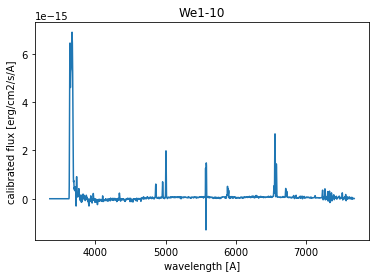

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

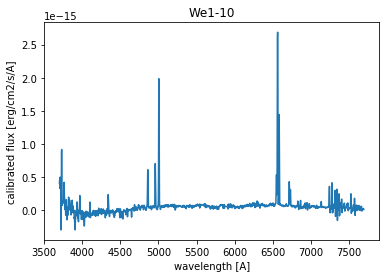

time =  2016-07-17 04:47:35
datestr = <170716>
airmass =  1.168824
{'SkyLeft': [1090, 1190], 'ObjectAreas': [[1244, 1301], [1326, 1375]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1390, 1505], 'ylim': [-5e-16, 4.2e-15], 'OName': 'KTC1'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/We1-10_GT170716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  106


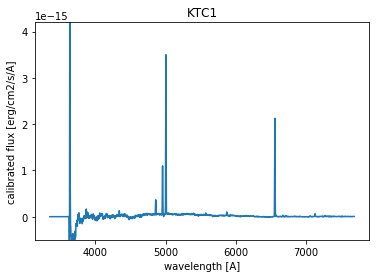

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

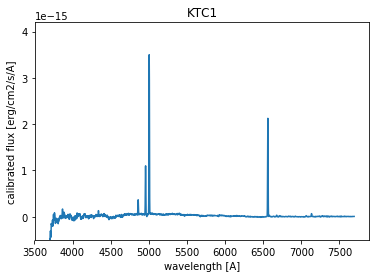

time =  2016-08-20 01:30:21
datestr = <200816>
airmass =  1.353607
{'SkyLeft': [1090, 1260], 'ObjectAreas': [[1301, 1326], [1340, 1354]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1388, 1506], 'ylim': [-2e-16, 2e-15], 'OName': 'Kn30'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/KTC1_GT200816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  39


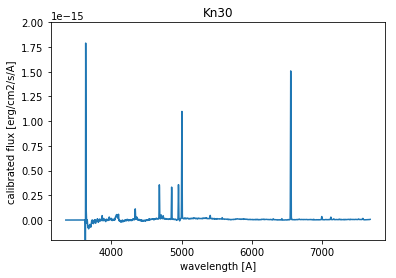

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

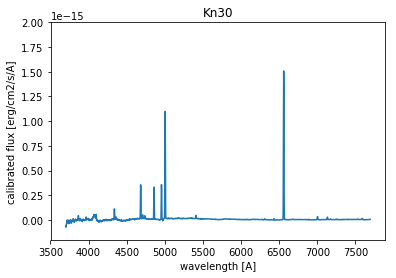

time =  2016-05-25 04:01:55
datestr = <250516>
airmass =  1.310601
{'SkyLeft': [496, 900], 'ObjectAreas': [[1172, 1222], [1240, 1301], [1322, 1495]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1611, 1720], 'ylim': [0, 0], 'OName': 'Kn31'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn30_GT250516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  284


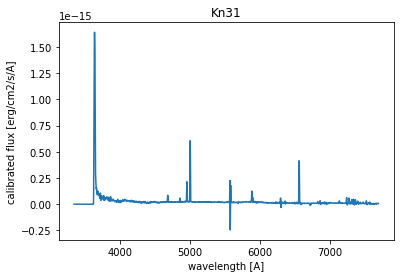

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

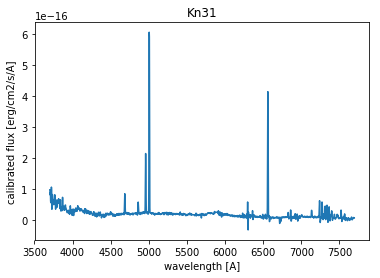

time =  2016-08-14 03:26:15
datestr = <140816>
airmass =  1.465902
{'SkyLeft': [688, 956], 'ObjectAreas': [[974, 1038], [1128, 1188], [1206, 1288], [1308, 1514], [1537, 1554], [1570, 1662]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1764, 1878], 'ylim': [0, 0], 'OName': ''}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn31_GT140816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  521


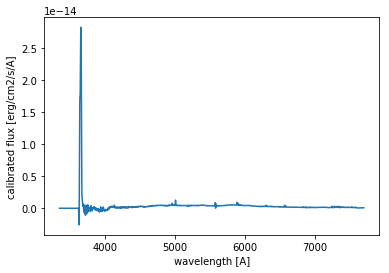

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

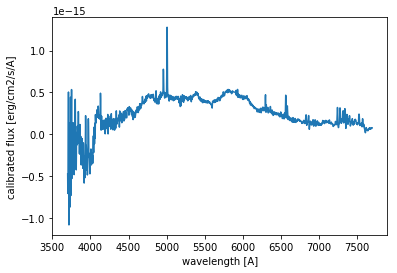

time =  2016-08-22 04:04:21
datestr = <220816>
airmass =  1.229395
{'SkyLeft': [802, 1031], 'ObjectAreas': [[1150, 1222], [1251, 1276], [1301, 1397]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1696, 1866], 'ylim': [-5e-16, 8e-16], 'OName': 'IPHASXJ230323'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/_GT220816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  193


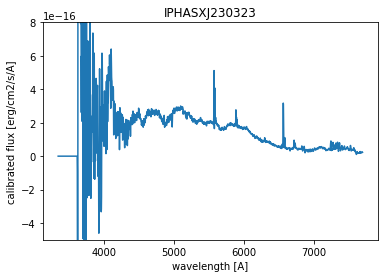

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

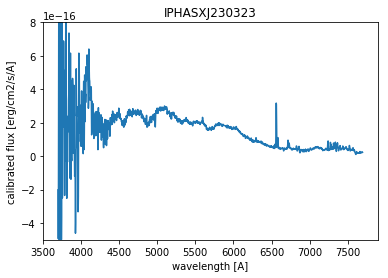

time =  2016-08-20 03:02:49
datestr = <200816>
airmass =  1.210315
{'SkyLeft': [520, 716], 'ObjectAreas': [[1259, 1375]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1685, 1794], 'ylim': [-3e-16, 1.5e-15], 'OName': 'IPHASXJ010133'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ230323_GT200816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  116


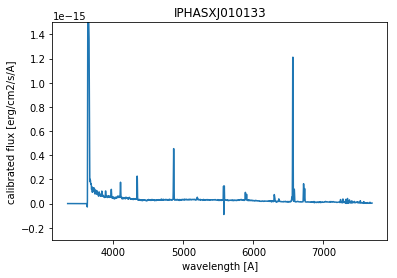

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

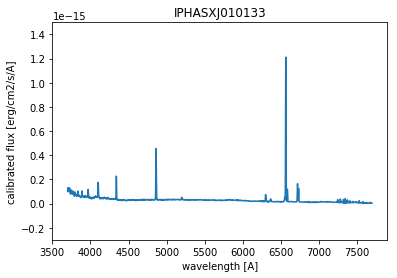

time =  2016-08-29 04:44:57
datestr = <290816>
airmass =  1.013295
{'SkyLeft': [185, 390], 'ObjectAreas': [[790, 820], [830, 849], [861, 871], [901, 974], [1004, 1035], [1101, 1146], [1168, 1201], [1222, 1236], [1256, 1301], [1344, 1410], [1432, 1495], [1515, 1543], [1728, 1756], [1772, 1789]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1819, 1983], 'ylim': [-1.8e-15, 3.8e-15], 'OName': 'Ju1'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ010133_GT290816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  502


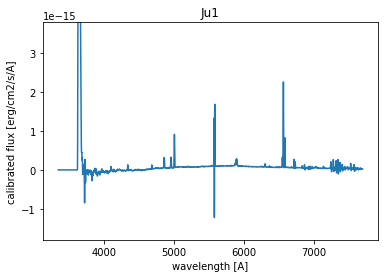

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

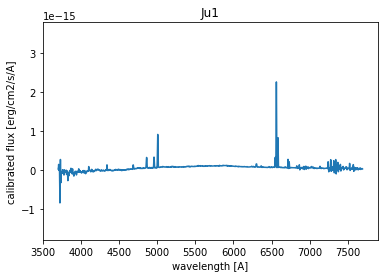

time =  2016-06-11 03:54:17
datestr = <110616>
airmass =  1.358267
{'SkyLeft': [391, 688], 'ObjectAreas': [[1200, 1300], [1319, 1448]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1847, 1978], 'ylim': [-4e-16, 1e-15], 'OName': 'Kn51'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Ju1_GT110616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  229


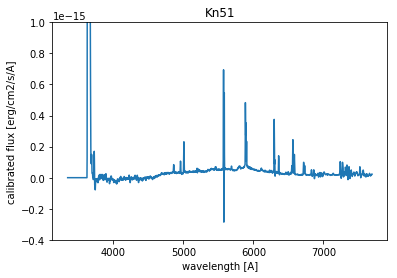

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

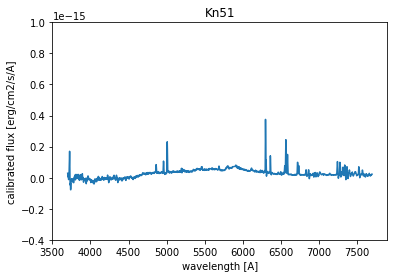

time =  2016-03-01 22:07:58
datestr = <010316>
airmass =  1.213132
{'SkyLeft': [695, 817], 'ObjectAreas': [[1131, 1164], [1176, 1186]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1650, 1809], 'ylim': [-1e-16, 1.5e-16], 'OName': 'FsMv1'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn51_GT010316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  43


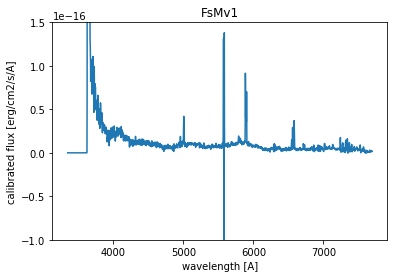

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

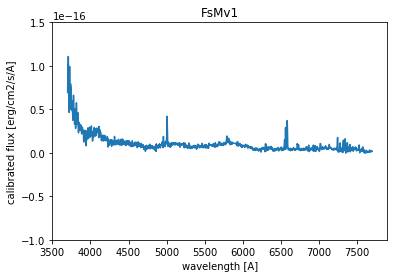

time =  2016-08-10 03:35:45
datestr = <100816>
airmass =  1.145947
{'SkyLeft': [1142, 1244], 'ObjectAreas': [[1284, 1298], [1329, 1351]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1395, 1530], 'ylim': [-2e-17, 1.5e-16], 'OName': 'KnJ0240'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/FsMv1_GT100816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  36


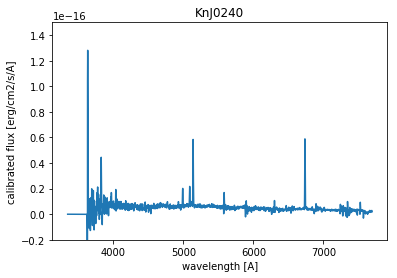

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

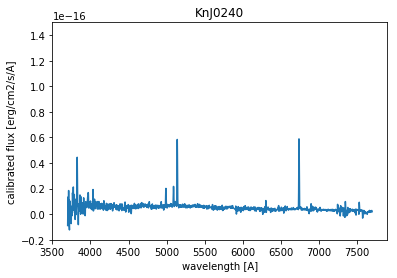

time =  2016-08-13 04:47:12
datestr = <130816>
airmass =  1.054217
{'SkyLeft': [810, 913], 'ObjectAreas': [[1221, 1288], [1337, 1374]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1874, 2014], 'ylim': [0, 4e-16], 'OName': 'KnJ1857'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/KnJ0240_GT130816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  104


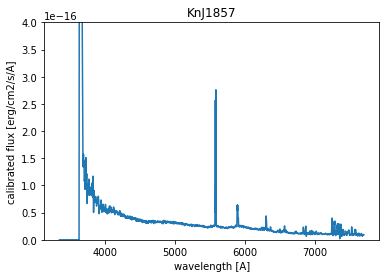

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

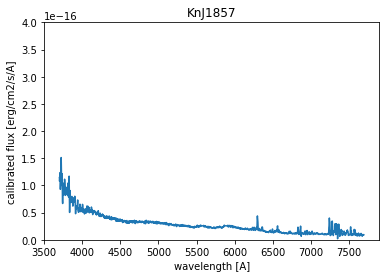

time =  2016-06-14 03:40:49
datestr = <140616>
airmass =  1.177084
{'SkyLeft': [1291, 1303], 'ObjectAreas': [[1312, 1356]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1359, 1380], 'ylim': [-3e-16, 8e-16], 'OName': 'IPHASXJ214032'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/KnJ1857_GT140616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  44


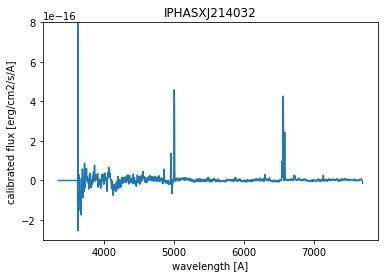

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

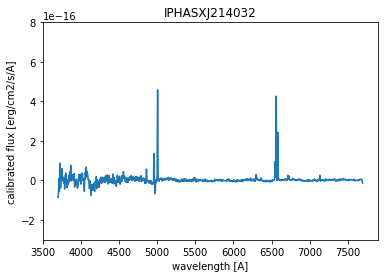

time =  2016-05-25 05:10:29
datestr = <250516>
airmass =  1.000538
{'SkyLeft': [1185, 1214], 'ObjectAreas': [[1277, 1299], [1320, 1329]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1687, 1748], 'ylim': [-5e-17, 5e-16], 'OName': 'DSHJ192315'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ214032_GT250516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  31


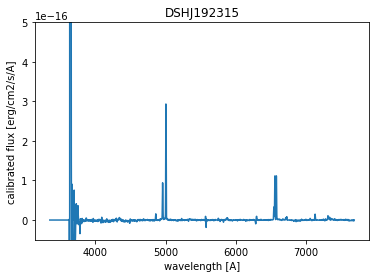

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

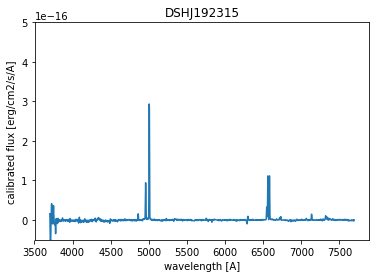

time =  2016-07-08 01:24:16
datestr = <080716>
airmass =  1.007563
{'SkyLeft': [908, 965], 'ObjectAreas': [[1090, 1280], [1436, 1556]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1745, 1890], 'ylim': [0, 1.5e-15], 'OName': 'DSHJ204858'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/DSHJ192315_GT080716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  310


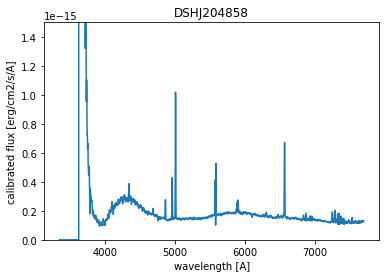

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

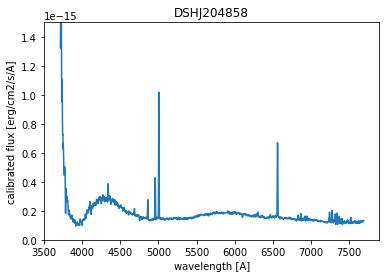

time =  2016-07-08 03:16:59
datestr = <080716>
airmass =  1.230875
{'SkyLeft': [878, 964], 'ObjectAreas': [[1296, 1332]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1570, 1606], 'ylim': [-1e-16, 9e-16], 'OName': 'Kn20'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/DSHJ204858_GT080716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  36


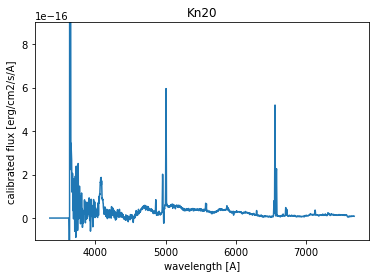

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

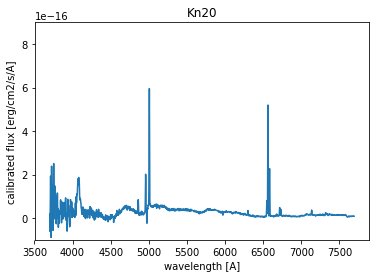

time =  2016-08-20 02:13:04
datestr = <200816>
airmass =  1.024165
{'SkyLeft': [708, 799], 'ObjectAreas': [[1214, 1257], [1288, 1295], [1325, 1354], [1383, 1394]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1603, 1655], 'ylim': [-1e-16, 1e-15], 'OName': 'DSHJ195813'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn20_GT200816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  90


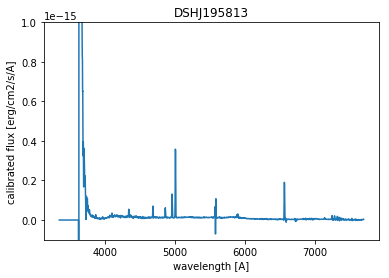

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

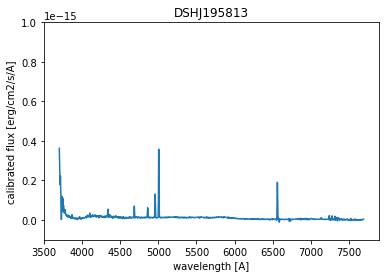

time =  2016-07-08 02:21:42
datestr = <080716>
airmass =  1.246408
{'SkyLeft': [1090, 1185], 'ObjectAreas': [[1285, 1303], [1322, 1340]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1412, 1511], 'ylim': [0, 0], 'OName': 'Kn59'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/DSHJ195813_GT080716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  36


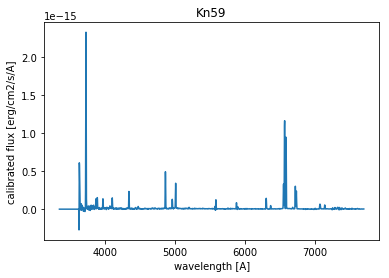

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

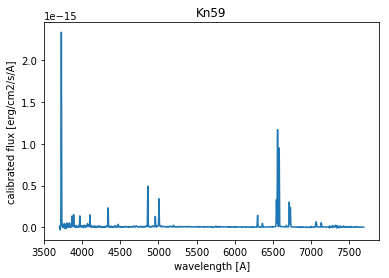

time =  2016-05-16 03:44:31
datestr = <160516>
airmass =  1.239819
{'SkyLeft': [406, 744], 'ObjectAreas': [[1125, 1252], [1270, 1302], [1337, 1503]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1528, 1633], 'ylim': [0, 0], 'OName': 'Kn61'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn59_GT160516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  325


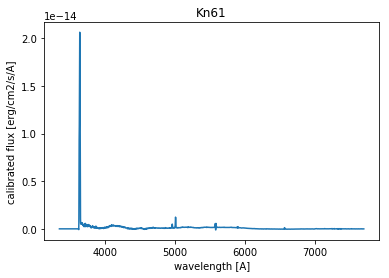

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

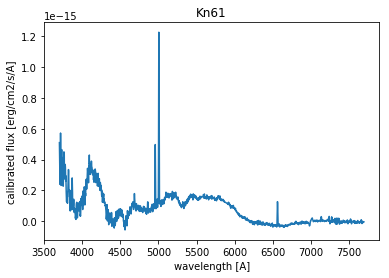

time =  2016-04-25 03:19:15
datestr = <250416>
airmass =  1.144021
{'SkyLeft': [286, 446], 'ObjectAreas': [[1170, 1297], [1324, 1471]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1752, 1939], 'ylim': [-2e-15, 2e-15], 'OName': 'Alves1'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn61_GT250416.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  274


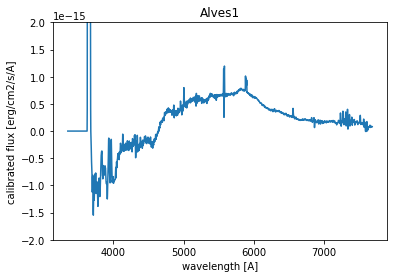

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

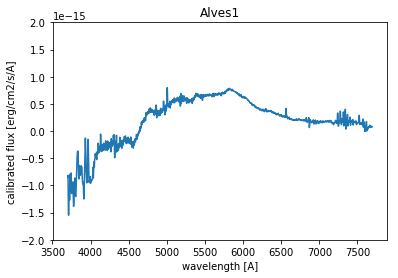

time =  2016-08-21 02:32:15
datestr = <210816>
airmass =  1.072673
{'SkyLeft': [1090, 1143], 'ObjectAreas': [[1291, 1304], [1317, 1329]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1348, 1403], 'ylim': [0, 0], 'OName': 'DSHJ205943'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Alves1_GT210816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  25


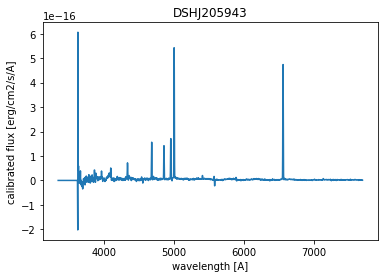

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

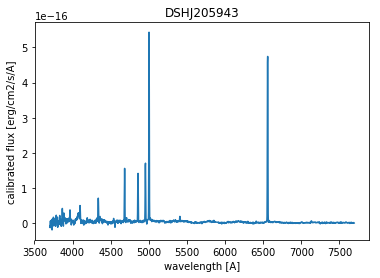

time =  2016-05-26 04:19:21
datestr = <260516>
airmass =  1.241557
{'SkyLeft': [1123, 1257], 'ObjectAreas': [[1274, 1323], [1342, 1385]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1440, 1512], 'ylim': [0, 0], 'OName': 'Ou5'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/DSHJ205943_GT260516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  92


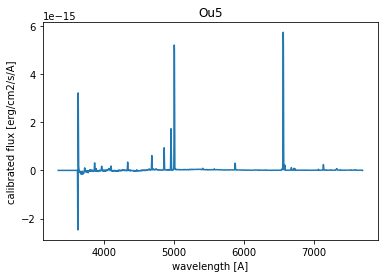

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

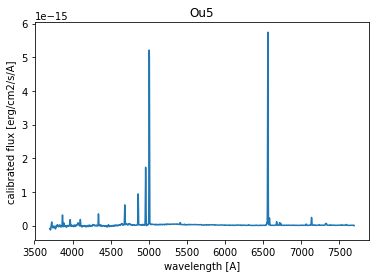

time =  2016-05-25 03:18:48
datestr = <250516>
airmass =  1.212524
{'SkyLeft': [811, 1028], 'ObjectAreas': [[1113, 1135], [1160, 1213], [1225, 1278], [1301, 1332], [1366, 1430], [1472, 1518], [1524, 1561], [1566, 1608]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1677, 1790], 'ylim': [0, 0], 'OName': 'DSHJ062355'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Ou5_GT250516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  348


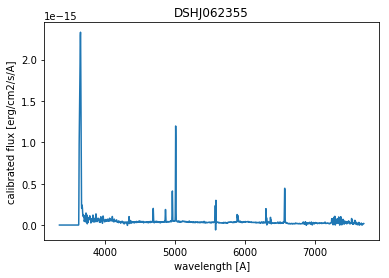

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

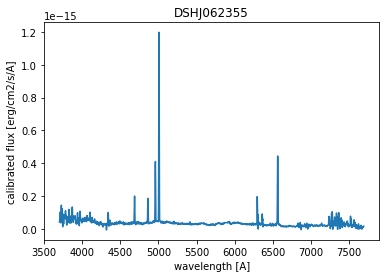

time =  2016-03-07 23:02:17
datestr = <070316>
airmass =  1.124513
{'SkyLeft': [336, 404], 'ObjectAreas': [[944, 998], [1012, 1038], [1090, 1110], [1138, 1150], [1168, 1220], [1254, 1270], [1284, 1354], [1382, 1412], [1440, 1460], [1486, 1510], [1542, 1552], [1572, 1586], [1602, 1610], [1626, 1652]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1836, 1916], 'ylim': [0, 0], 'OName': 'IPHASXJ193849'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/DSHJ062355_GT070316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  382


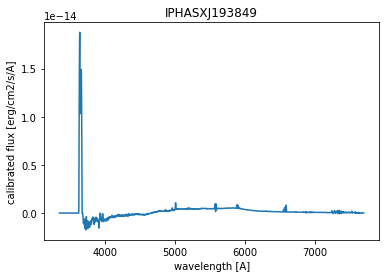

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

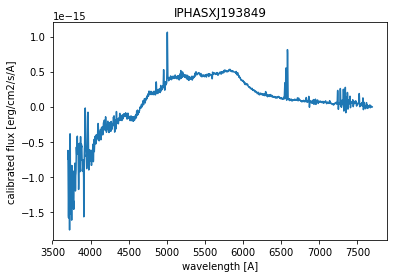

time =  2016-08-22 00:43:24
datestr = <220816>
airmass =  1.190593
{'SkyLeft': [831, 909], 'ObjectAreas': [[1128, 1263], [1284, 1300], [1322, 1327], [1391, 1401], [1406, 1443], [1448, 1483]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1800, 1984], 'ylim': [0, 0], 'OName': 'Ou2'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ193849_GT220816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  238


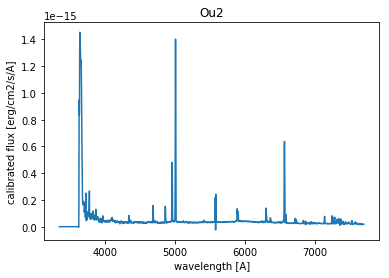

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

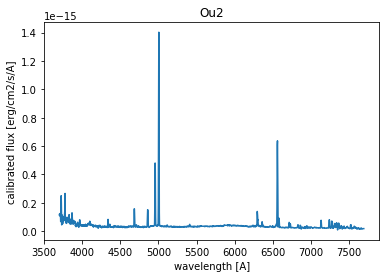

time =  2016-08-14 04:24:51
datestr = <140816>
airmass =  1.164003
{'SkyLeft': [512, 772], 'ObjectAreas': [[871, 1038], [1090, 1400], [1426, 1560], [1567, 1657]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1677, 1777], 'ylim': [-3e-15, 2e-15], 'OName': 'We2-260'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Ou2_GT140816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  701


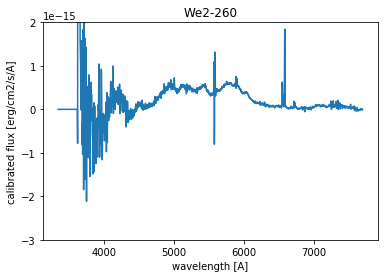

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

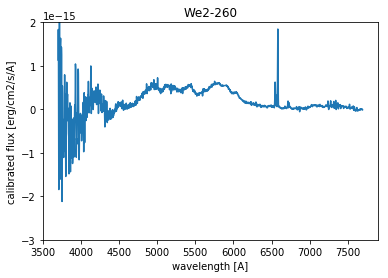

time =  2016-08-21 03:23:54
datestr = <210816>
airmass =  1.239273
{'SkyLeft': [714, 954], 'ObjectAreas': [[1167, 1292], [1335, 1369], [1386, 1406], [1419, 1436]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1524, 1578], 'ylim': [-1e-15, 6e-15], 'OName': 'Si1-2'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/We2-260_GT210816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  196


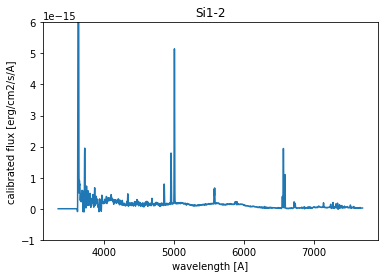

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

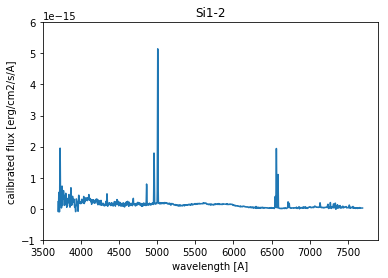

time =  2016-05-16 01:46:01
datestr = <160516>
airmass =  1.254448
{'SkyLeft': [719, 956], 'ObjectAreas': [[1247, 1321], [1370, 1449]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1784, 1987], 'ylim': [-1e-15, 1e-15], 'OName': 'IPHASXJ023538'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Si1-2_GT160516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  153


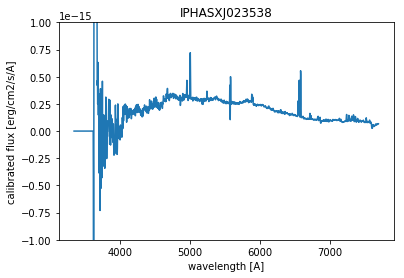

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

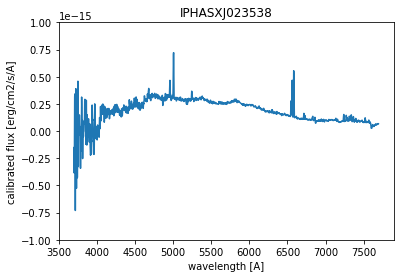

time =  2016-08-21 04:19:31
datestr = <210816>
airmass =  1.016772
{'SkyLeft': [926, 1034], 'ObjectAreas': [[1227, 1274]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1600, 1847], 'ylim': [0, 0], 'OName': 'DSHJ202907'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ023538_GT210816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  47


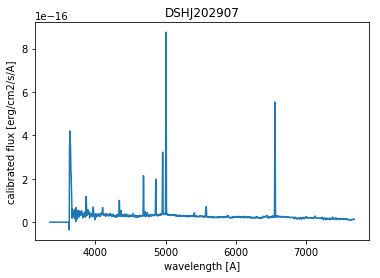

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

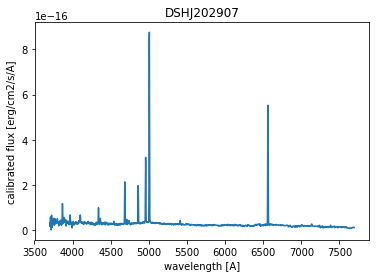

time =  2016-06-13 04:49:19
datestr = <130616>
airmass =  1.41189
{'SkyLeft': [839, 935], 'ObjectAreas': [[1173, 1216], [1323, 1344], [1509, 1558], [1622, 1650], [1697, 1737]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1740, 1823], 'ylim': [-5e-17, 1e-16], 'OName': 'Pa30'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/DSHJ202907_GT130616.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  181


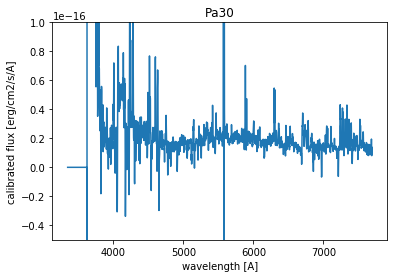

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

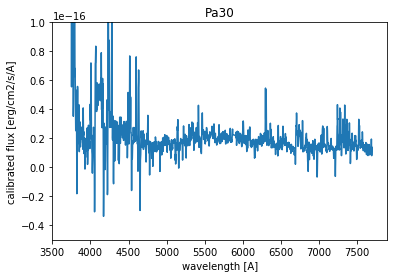

time =  2016-07-08 04:16:41
datestr = <080716>
airmass =  1.4675
{'SkyLeft': [394, 486], 'ObjectAreas': [[711, 766], [796, 916], [936, 997], [1020, 1038], [1131, 1208], [1365, 1565], [1707, 1765], [1799, 1822]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1964, 2025], 'ylim': [0, 0], 'OName': 'ldu18'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Pa30_GT080716.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  612


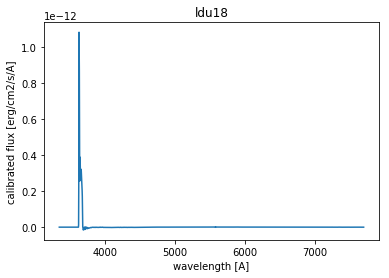

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

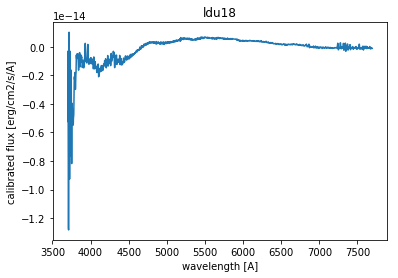

time =  2016-08-21 02:04:07
datestr = <210816>
airmass =  1.260285
{'SkyLeft': [395, 487], 'ObjectAreas': [[712, 767], [797, 875], [896, 917], [938, 998], [1021, 1038], [1132, 1209], [1366, 1401], [1422, 1470], [1502, 1561], [1708, 1766], [1800, 1823]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1965, 2026], 'ylim': [-1e-15, 2e-15], 'OName': 'HaWe15'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/ldu18_GT210816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  531


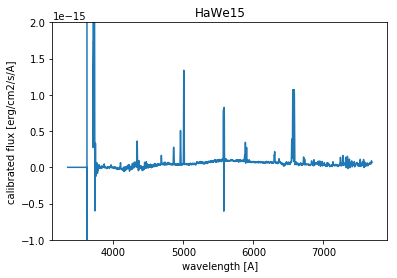

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

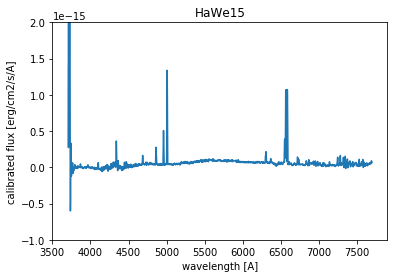

time =  2016-08-16 04:41:23
datestr = <160816>
airmass =  1.171792
{'SkyLeft': [710, 772], 'ObjectAreas': [[879, 1037], [1090, 1125], [1143, 1233], [1251, 1297], [1397, 1446], [1514, 1711], [1742, 1786], [1846, 1907]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1925, 1973], 'ylim': [-2e-16, 5e-15], 'OName': 'We2-5'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/HaWe15_GT160816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  680


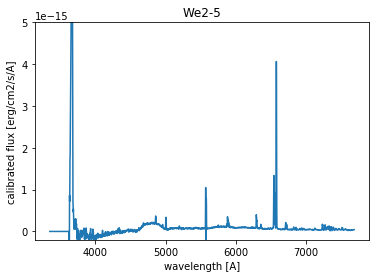

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

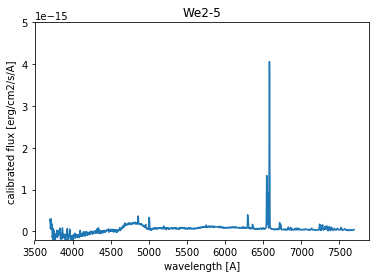

time =  2016-08-26 04:17:31
datestr = <260816>
airmass =  1.130693
{'SkyLeft': [702, 1017], 'ObjectAreas': [[1136, 1299], [1325, 1409], [1437, 1479]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1560, 1740], 'ylim': [-5e-16, 3e-15], 'OName': 'KLSS2-8'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/We2-5_GT260816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  289


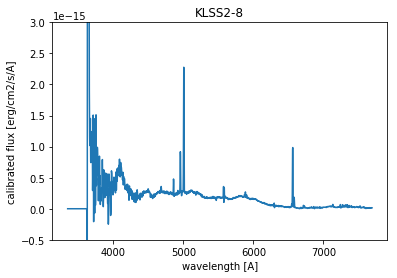

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

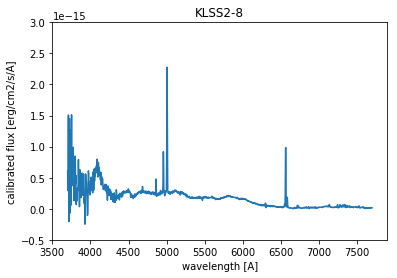

time =  2016-08-20 04:53:10
datestr = <200816>
airmass =  1.160276
{'SkyLeft': [1149, 1211], 'ObjectAreas': [[1283, 1303], [1322, 1359]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1625, 1663], 'ylim': [-5e-16, 9e-15], 'OName': 'PM1-305'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/KLSS2-8_GT200816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  57


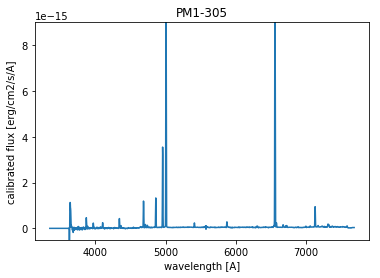

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

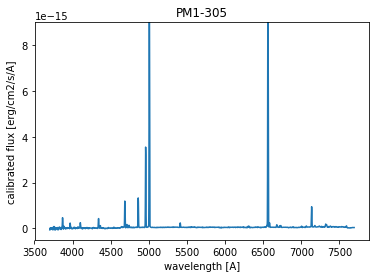

time =  2016-05-16 02:53:37
datestr = <160516>
airmass =  1.349188
{'SkyLeft': [778, 891], 'ObjectAreas': [[1305, 1351], [1376, 1418]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1791, 1879], 'ylim': [-5e-17, 5e-15], 'OName': 'Kn33'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/PM1-305_GT160516.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  88


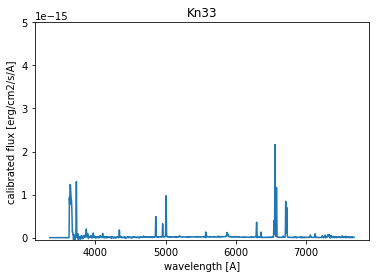

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

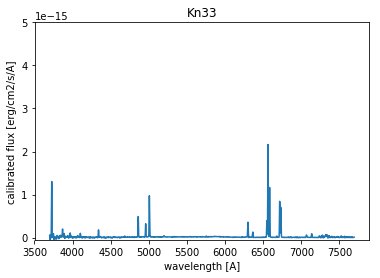

time =  2016-03-07 21:29:51
datestr = <070316>
airmass =  1.096529
{'SkyLeft': [860, 962], 'ObjectAreas': [[1195, 1295], [1318, 1378]], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1577, 1769], 'ylim': [-5e-16, 1e-15], 'OName': 'KKR62'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/Kn33_GT070316.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  160


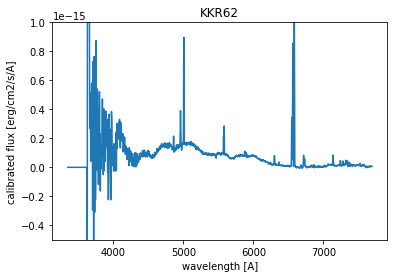

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing f

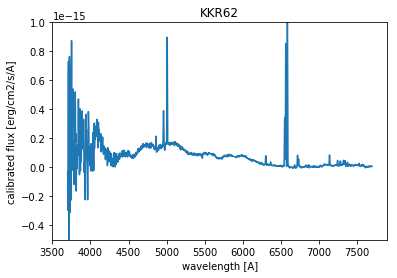

time =  2016-08-21 00:54:21
datestr = <210816>
airmass =  1.139633
{'SkyLeft': [429, 475], 'ObjectAreas': [[929, 972], [992, 1038], [1090, 1116], [1157, 1196], [1234, 1288], [1322, 1348], [1376, 1403], [1471, 1526], [1640, 1665], [1688, 1714]], 'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1780, 1837], 'ylim': [0, 0], 'OName': 'IPHASXJ191306.1+025248'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/KKR62_GT210816.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  367


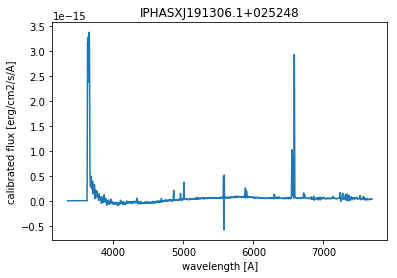

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

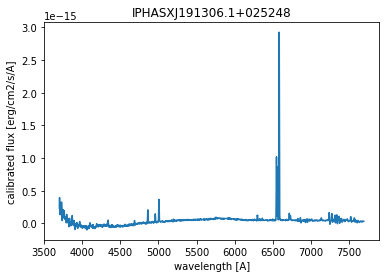

time =  2018-05-16 03:58:28
datestr = <160518>


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ191306.1+025248_GT160518.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


airmass =  1.077816
{'SkyLeft': [717, 921], 'ObjectAreas': [[1267, 1338]], 'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1567, 1756], 'ylim': [-2e-17, 1.5e-16], 'OName': 'IPHASXJ190543.8+064413'}
nCols =  71


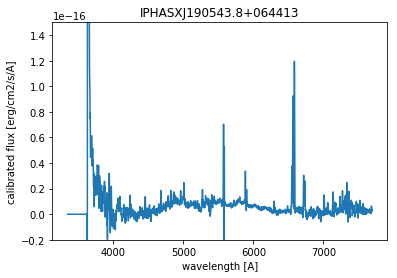

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

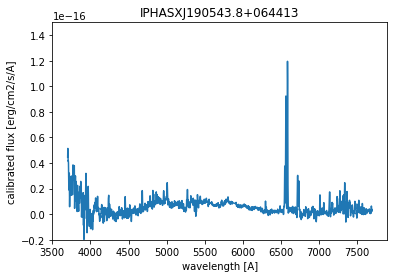

time =  2018-05-16 04:42:22
datestr = <160518>
airmass =  1.209664
{'SkyLeft': [840, 920], 'ObjectAreas': [[1277, 1292], [1309, 1317], [1337, 1368]], 'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1608, 1674], 'ylim': [-1e-16, 2.5e-16], 'OName': 'IPHASXJ191058.9+040350'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ190543.8+064413_GT160518.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  54


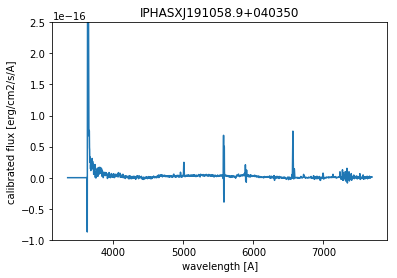

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

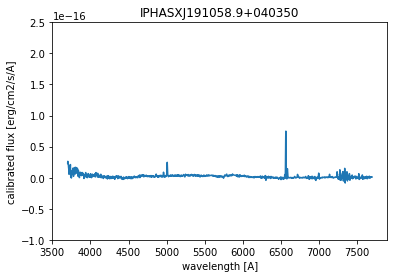

time =  2018-05-17 03:04:14
datestr = <170518>
airmass =  1.318294
{'SkyLeft': [786, 1019], 'ObjectAreas': [[1277, 1323], [1345, 1362]], 'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1411, 1512], 'ylim': [0, 0], 'OName': 'IPHASXJ191104.8+060845'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ191058.9+040350_GT170518.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  63


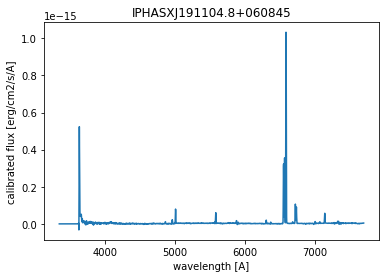

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

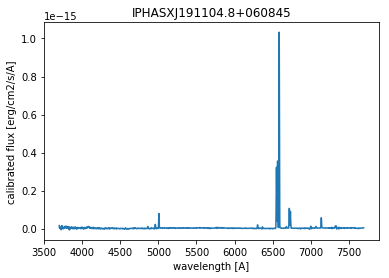

time =  2018-05-17 02:21:06
datestr = <170518>
airmass =  1.153729
{'SkyLeft': [670, 708], 'ObjectAreas': [[1230, 1271], [1300, 1317], [1351, 1385], [1420, 1453]], 'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1951, 2005], 'ylim': [-2.5e-16, 2.5e-16], 'OName': 'IPHASXJ191707.3+020010'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ191104.8+060845_GT170518.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  125


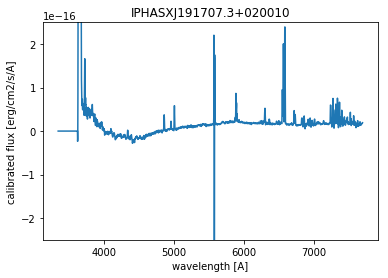

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

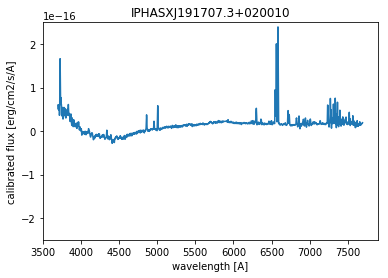

time =  2018-05-17 03:53:04
datestr = <170518>
airmass =  1.045841
{'SkyLeft': [1090, 1186], 'ObjectAreas': [[1251, 1284], [1323, 1328], [1340, 1395]], 'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'SkyRight': [1451, 1557], 'ylim': [-2e-16, 2e-15], 'OName': 'IPHASXJ191918.8+171148'}


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ191707.3+020010_GT170518.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


nCols =  93


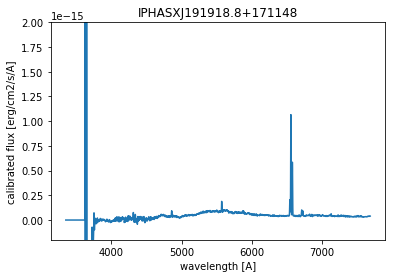

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existin

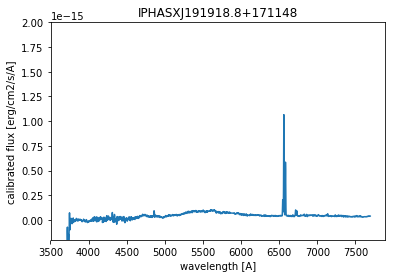

time =  2018-04-29 05:08:15
datestr = <290418>


/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ191918.8+171148_GT290418.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


In [7]:
tab = [
#{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_wl_cal.fits', 'ylim' : [-0.15e-15,0.3e-15], 'OName': 'IPHASXJ194645', 'SkyLeft':[835,960], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ194645', 'SkyLeft':[835,960], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,1.3e-15], 'OName': 'Kn19', 'SkyLeft':[1141,1166], 'SkyRight':[1474,1504], 'ObjectAreas':[[1200,1228],[1251,1306],[1321,1340],[1358,1407],[1425,1450]]},#looks good
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.2e-15], 'OName': 'Kn45', 'SkyLeft':[1184,1228], 'SkyRight':[1320,1374], 'ObjectAreas':[[1238,1296]]},#okay, diffuse extended object with continuum
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ205811', 'SkyLeft':[889,991], 'SkyRight':[1546,1608], 'ObjectAreas':[[1090,1256],[1326,1540]]},#faint line at 5005, very extended object with sky from both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-14,0.2e-14], 'OName': 'DSHJ221013', 'SkyLeft':[680,780], 'SkyRight':[1626,1704], 'ObjectAreas':[[1090,1292],[1334,1380],[1404,1429],[1479,1506],[1538,1554]]},#okay, line at 6562, very extended object with sky from both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.15e-15], 'OName': 'IPHASXJ194745', 'SkyLeft':[1188,1218], 'SkyRight':[1544,1560], 'ObjectAreas':[[1300,1396]]},#hmmm, run that and try with sky from other image - did try that, still nothing to be seen here
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.1e-14], 'OName': 'Ou3', 'SkyLeft':[1126,1132], 'SkyRight':[1503,1515], 'ObjectAreas':[[1133,1150],[1189,1226],[1241,1300],[1318,1331],[1342,1389],[1407,1432],[1445,1468],[1494,1502]]},#looks good, line at 5004, very extended
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-14,0.4e-14], 'OName': 'Kn24', 'SkyLeft':[895,915], 'SkyRight':[1753,1790], 'ObjectAreas':[[916,1038],[1090,1180],[1198,1303],[1320,1556],[1566,1700]]},#looks good, line at 5004, very extended, on both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-16,2.0e-16], 'OName': 'LDu1', 'SkyLeft':[440,570], 'SkyRight':[1837,1918], 'ObjectAreas':[[1106,1134],[1150,1194],[1254,1320],[1338,1348],[1496,1594]]},#looks good, line at 5004 and 6582, very extended, sky from both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.5e-15], 'OName': 'IPHASXJ193617', 'SkyLeft':[1263,1288], 'SkyRight':[1423,1479], 'ObjectAreas':[[1293,1307],[1320,1331]]},#looks good, pretty compact
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-15,0.5e-15], 'OName': 'IPHASXJ194728', 'SkyLeft':[1177,1197], 'SkyRight':[1395,1414], 'ObjectAreas':[[1248,1273],[1287,1306],[1323,1350],[1365,1374]]},#looks good, lines at 6716,...
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-14,0.8e-14], 'OName': 'IPHASXJ194301', 'SkyLeft':[1218,1248], 'SkyRight':[1333,1363], 'ObjectAreas':[[1272,1325]]},#looks good, pretty compact, lines at 6585, 6562
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.5e-15], 'OName': 'IPHASXJ194301', 'SkyLeft':[1244,1269], 'SkyRight':[1357,1385], 'ObjectAreas':[[1284,1304],[1324,1348]]},#looks good, pretty compact, lines at 6585, 6562
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'PNG124.1-01.9', 'SkyLeft':[1150,1177], 'SkyRight':[1376,1399], 'ObjectAreas':[[1299,1350]]},#looks good, lines at 4859 and 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-14,0.8e-14], 'OName': 'IPHASXJ014238+600947', 'SkyLeft':[785,816], 'SkyRight':[1930,1956], 'ObjectAreas':[[864,953],[968,1038],[1091,1126],[1138,1303],[1318,1424],[1440,1558],[1564,1595],[1612,1680],[1703,1720],[1759,1902]]},#looks good, lines at 6584, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ031058.8+624755', 'SkyLeft':[243,324], 'SkyRight':[1961,1985], 'ObjectAreas':[[363,457],[478,542],[559,576],[594,726],[743,786],[834,855],[872,897],[910,1038],[1090,1194],[1221,1273],[1328,1436],[1505,1560],[1596,1760],[1785,1850],[1877,1909],[1928,1950]]},#looks good at 4957 and 6579, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.5e-15], 'OName': 'IPHASXj040721.5+512422', 'SkyLeft':[424,522], 'SkyRight':[1842,1891], 'ObjectAreas':[[1197,1303],[1320,1450]]},#looks good, lines at 4959, 5004, 6580, 6716, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-13,0.1e-13], 'OName': 'IPHASXJ051152.2+302751', 'SkyLeft':[662,700], 'SkyRight':[1884,1925], 'ObjectAreas':[[701,1035],[1124,1154],[1171,1300],[1325,1555],[1607,1880]]},#faint emission at 6562, 6580, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.15e-14,0.1e-14], 'OName': 'IPHASXJ053650.8+245616', 'SkyLeft':[1170,199], 'SkyRight':[1511,1541], 'ObjectAreas':[[1201,1300],[1320,1474]]},#faint lines around 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-14,1.5e-14], 'OName': 'IPHASXJ055242.8+262116', 'SkyLeft':[1233,1248], 'SkyRight':[1534,1545], 'ObjectAreas':[[1265,1294],[1327,1466]]},#looks good, compact, 4959, 5008, 6563
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-16,1.5e-16], 'OName': 'IPHASXJ185322.1+083018', 'SkyLeft':[1213,1236], 'SkyRight':[1542,1557], 'ObjectAreas':[[1256,1283],[1322,1358],[1414,1448],[1491,1537]]},#shell visible at 5005
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-14,0.5e-14], 'OName': 'IPHASXJ191306.1+025248', 'SkyLeft':[572,606], 'SkyRight':[1836,1878], 'ObjectAreas':[[754,801],[846,870],[882,977],[985,1002],[1011,1038],[1132,1183],[1196,1223],[1245,1304],[1346,1390],[1519,1534],[1565,1626],[1635,1696],[1714,1746],[1758,1806]]},#clear shell at 6583, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.2e-15], 'OName': 'SNR060707', 'SkyLeft':[768,828], 'SkyRight':[1698,1742], 'ObjectAreas':[[888,958],[1101,1152],[1180,1210],[1245,1299],[1309,1350],[1368,1399],[1425,1478],[1491,1560]]},#lines at 6561, 6584, without extended regions near the center
#{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.2e-15], 'OName': 'SNR060707', 'SkyLeft':[325,513], 'SkyRight':[1936,2021], 'ObjectAreas':[[888,958],[1101,1299],[1309,1350],[1368,1399],[1425,1478],[1491,1560]]},#lines at 6561, 6584, with extended regions near the center
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-15,0.5e-15], 'OName': 'SNR060715', 'SkyLeft':[683,738], 'SkyRight':[1718,2004], 'ObjectAreas':[[1256,1300],[1325,1388]]},#ok, some lines at 6563, 6717, bright object bleeding into the nebula, mysterious
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-15,0.5e-15], 'OName': 'SNR060930', 'SkyLeft':[744,935], 'SkyRight':[1788,1927], 'ObjectAreas':[[1126,1242],[1258,1348],[1408,1555]]},#possible line at 6566, mysterious
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'KK26', 'SkyLeft':[680,920], 'SkyRight':[1730,2014], 'ObjectAreas':[[1112,1283],[1305,1559]]},#very nice blobs
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-15,0.5e-15], 'OName': 'Kn34', 'SkyLeft':[1110,1160], 'SkyRight':[1468,1505], 'ObjectAreas':[[1163,1183],[1218,1234],[1270,1295],[1325,1357],[1394,1443]]},#ok, lines at 4861, 4960, 5006, problematic sky lines at 6300 and 6330
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.2e-15], 'OName': 'CR1', 'SkyLeft':[872,919], 'SkyRight':[1926,2025], 'ObjectAreas':[[1109,1158],[1167,1179],[1190,1263],[1284,1320],[1361,1456],[1470,1513],[1522,1529],[1543,1561],[1564,1625]]},#ok, lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-17,5.0e-17], 'OName': 'Kn11', 'SkyLeft':[1253,1277], 'SkyRight':[1345,1377], 'ObjectAreas':[[1278,1300],[1318,1340]]},#okay, compact, lines 6547, 6562, 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'HaWe3', 'SkyLeft':[1140,1225], 'SkyRight':[1395,1422], 'ObjectAreas':[[1229,1298],[1323,1391]]},#okay, lines at 4958, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn48', 'SkyLeft':[1120,1190], 'SkyRight':[1442,1470], 'ObjectAreas':[[1216,1253],[1265,1301],[1321,1332],[1348,1389],[1410,1420]]},#okay lines at 4861, 4958, 5006
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-15,9.0e-15], 'OName': 'Kn58', 'SkyLeft':[1150,1190], 'SkyRight':[1434,1461], 'ObjectAreas':[[1195,1300],[1324,1337],[1358,1430]]},#okay, lines at 4955, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-15,1.9e-15], 'OName': 'Ou2', 'SkyLeft':[1114,1133], 'SkyRight':[1528,1552], 'ObjectAreas':[[1133,1346],[1405,1443],[1460,1475],[1494,1507]]},#okay, lines at 4955, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Abell68', 'SkyLeft':[1090,1168], 'SkyRight':[1432,1477], 'ObjectAreas':[[1188,1305],[1317,1368],[1379,1397]]},#okay, lines at 4684, 4861, 4958, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-14,0.5e-14], 'OName': 'Kn24', 'SkyLeft':[887,939], 'SkyRight':[1703,1758], 'ObjectAreas':[[945,998],[1013,1036],[1090,1241],[1254,1303],[1338,1400],[1453,1558],[1581,1702]]},#hmmm, possible line at 6585, very extended object over both CCDs
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[718,748], 'SkyRight':[1825,1842], 'ObjectAreas':[[1164,1212],[1241,1252],[1268,1282],[1307,1353],[1367,1407],[1435,1445],[1495,1516],[1530,1556],[1602,1650],[1670,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.21e-14,0.4e-14], 'OName': 'K1-6', 'SkyLeft':[314,732], 'SkyRight':[1680,1957], 'ObjectAreas':[[957,1036],[1090,1132],[1148,1233],[1398,1582]]},#okay, lines at 4861, 4959, 5005, very wide bright object in the center
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.6e-15,1.8e-15], 'OName': 'LDu1', 'SkyLeft':[407,717], 'SkyRight':[1847,2020], 'ObjectAreas':[[1090,1166],[1182,1226],[1238,1304],[1315,1350],[1395,1452],[1465,1480],[1492,1550],[1564,1573],[1588,1642]]},
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-15,0.2e-15], 'OName': 'IPHASXJ195627', 'SkyLeft':[1090,1178], 'SkyRight':[1438,1505], 'ObjectAreas':[[1259,1337]]},#Hmmm, faint line at 6563
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-16,2.7e-16], 'OName': 'IRAS20084', 'SkyLeft':[1128,1206], 'SkyRight':[1681,1780], 'ObjectAreas':[[1290,1299],[1325,1329]]},#nothing really but HASH shows compact cloud in 432
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-15,0.7e-15], 'OName': 'IPHASXJ201058', 'SkyLeft':[637,914], 'SkyRight':[1671,1781], 'ObjectAreas':[[1213,1266],[1288,1340]]},#faint lines at 6565 and 6585
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-15,2.0e-15], 'OName': 'Kn36', 'SkyLeft':[366,547], 'SkyRight':[1884,1940], 'ObjectAreas':[[1188,1300],[1345,1361],[1398,1420]]},#ok lines at 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'We2-260', 'SkyLeft':[404,580], 'SkyRight':[1782,1982], 'ObjectAreas':[[800,957],[978,1038],[1090,1240],[1262,1716]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ225420', 'SkyLeft':[536,696], 'SkyRight':[1571,1659], 'ObjectAreas':[[1192,1232],[1269,1432],[1311,1359]]},#line at 6559, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn25', 'SkyLeft':[445,489], 'SkyRight':[1614,1658], 'ObjectAreas':[[1171,1210],[1265,1280],[1331,1343],[1398,1433]]},#lines at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'We1-10', 'SkyLeft':[369,450], 'SkyRight':[1922,2023], 'ObjectAreas':[[752,839],[860,978],[994,1020],[1090,1195],[1209,1295],[1325,1402],[1423,1472],[1504,1554],[1570,1618],[1633,1658],[1679,1845]]},# line at 4959
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-15,4.2e-15], 'OName': 'KTC1', 'SkyLeft':[1090,1190], 'SkyRight':[1390,1505], 'ObjectAreas':[[1244,1301],[1326,1375]]},#easy, lines at 4957 and 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-15,2.0e-15], 'OName': 'Kn30', 'SkyLeft':[1090,1260], 'SkyRight':[1388,1506], 'ObjectAreas':[[1301,1326],[1340,1354]]},#easy, lines at 4859, 4957, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn31', 'SkyLeft':[496,900], 'SkyRight':[1611,1720], 'ObjectAreas':[[1172,1222],[1240,1301],[1322,1495]]},#okay, lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': '', 'SkyLeft':[688,956], 'SkyRight':[1764,1878], 'ObjectAreas':[[974,1038],[1128,1188],[1206,1288],[1308,1514],[1537,1554],[1570,1662]]},#lines at 5005, 6560, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.08e-14], 'OName': 'IPHASXJ230323', 'SkyLeft':[802,1031], 'SkyRight':[1696,1866], 'ObjectAreas':[[1150,1222],[1251,1276],[1301,1397]]},#faint line at 6561
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,1.5e-15], 'OName': 'IPHASXJ010133', 'SkyLeft':[520,716], 'SkyRight':[1685,1794], 'ObjectAreas':[[1259,1375]]},#line at 4859
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.8e-15,3.8e-15], 'OName': 'Ju1', 'SkyLeft':[185,390], 'SkyRight':[1819,1983], 'ObjectAreas':[[790,820],[830,849],[861,871],[901,974],[1004,1035],[1101,1146],[1168,1201],[1222,1236],[1256,1301],[1344,1410],[1432,1495],[1515,1543],[1728,1756],[1772,1789]]},#line at 1960
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.4e-15,1.0e-15], 'OName': 'Kn51', 'SkyLeft':[391,688], 'SkyRight':[1847,1978], 'ObjectAreas':[[1200,1300],[1319,1448]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-16,1.5e-16], 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[1131,1164],[1176,1186]]},#difficult, possible line at 6581, without extended objects
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-16,2.0e-16], 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[801,891],[1131,1164]]},#difficult, possible line at 6581, with left extended object
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033b/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.4e-15,0.7e-15], 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[1131,1164],[1205,1306]]},#difficult, possible line at 6581, with right extended object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-16,1.5e-16], 'OName': 'KnJ0240', 'SkyLeft':[1142,1244], 'SkyRight':[1395,1530], 'ObjectAreas':[[1284,1298],[1329,1351]]},#compact, lines at 4988, 5090, 5137
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,4.0e-16], 'OName': 'KnJ1857', 'SkyLeft':[810,913], 'SkyRight':[1874,2014], 'ObjectAreas':[[1221,1288],[1337,1374]]},#can't see lines just a possibly extended (compact) object in the center
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1291,1303], 'SkyRight':[1359,1380], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
##{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1090,1250], 'SkyRight':[1552,1661], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-15,0.5e-15], 'OName': 'DSHJ192315', 'SkyLeft':[1185,1214], 'SkyRight':[1687,1748], 'ObjectAreas':[[1277,1299],[1320,1329]]},#lines at 4961 and 5005, pretty compact object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0.15e-14], 'OName': 'DSHJ204858', 'SkyLeft':[908,965], 'SkyRight':[1745,1890], 'ObjectAreas':[[1090,1280],[1436,1556]]},#lines at 4860, 4958, 5005, central object gets wider in some wavelength ranges, saturated central? star bleeding into the nebula
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.9e-15], 'OName': 'Kn20', 'SkyLeft':[878,964], 'SkyRight':[1570,1606], 'ObjectAreas':[[1296,1332]]},#lines at 6563 and 6582, only on right side of a star (no central star visible?)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.1e-15,1.0e-15], 'OName': 'DSHJ195813', 'SkyLeft':[708,799], 'SkyRight':[1603,1655], 'ObjectAreas':[[1214,1257],[1288,1295],[1325,1354],[1383,1394]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Kn59', 'SkyLeft':[1090,1185], 'SkyRight':[1412,1511], 'ObjectAreas':[[1285,1303],[1322,1340]]},#compact, lines at 4861, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': '', 'SkyLeft':[406,744], 'SkyRight':[1528,1633], 'ObjectAreas':[[1125,1252],[1270,1302],[1337,1503]]},#lines at 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-15,2.0e-15], 'OName': 'Alves1', 'SkyLeft':[286,446], 'SkyRight':[1752,1939], 'ObjectAreas':[[1170,1297],[1324,1471]]},#nothing, without central object
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044a/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-15,2.0e-15], 'OName': 'Alves1', 'SkyLeft':[286,446], 'SkyRight':[1752,1939], 'ObjectAreas':[[1170,1471]]},#nothing, with central object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ205943', 'SkyLeft':[1090,1143], 'SkyRight':[1348,1403], 'ObjectAreas':[[1291,1304],[1317,1329]]},#compact, lines at 4858, 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Ou5', 'SkyLeft':[1123,1257], 'SkyRight':[1440,1512], 'ObjectAreas':[[1274,1323],[1342,1385]]},#lines at 4861, 4959, 5005, 5873
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ062355', 'SkyLeft':[811,1028], 'SkyRight':[1677,1790], 'ObjectAreas':[[1113,1135],[1160,1213],[1225,1278],[1301,1332],[1366,1430],[1472,1518],[1524,1561],[1566,1608]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ193849', 'SkyLeft':[336,404], 'SkyRight':[1836,1916], 'ObjectAreas':[[944,998],[1012,1038],[1090,1110],[1138,1150],[1168,1220],[1254,1270],[1284,1354],[1382,1412],[1440,1460],[1486,1510],[1542,1552],[1572,1586],[1602,1610],[1626,1652]]},#lines at 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'Ou2', 'SkyLeft':[831,909], 'SkyRight':[1800,1984], 'ObjectAreas':[[1128,1263],[1284,1300],[1322,1327],[1391,1401],[1406,1443],[1448,1483]]},#lines at 4684, 4957, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-14,0.2e-14], 'OName': 'We2-260', 'SkyLeft':[512,772], 'SkyRight':[1677,1777], 'ObjectAreas':[[871,1038],[1090,1400],[1426,1560],[1567,1657]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.1e-14,0.6e-14], 'OName': 'Si1-2', 'SkyLeft':[714,954], 'SkyRight':[1524,1578], 'ObjectAreas':[[1167,1292],[1335,1369],[1386,1406],[1419,1436]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,1.0e-15], 'OName': 'IPHASXJ023538', 'SkyLeft':[719,956], 'SkyRight':[1784,1987], 'ObjectAreas':[[1247,1321],[1370,1449]]},#faint continuum both sides of the central faint object (not included)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'DSHJ202907', 'SkyLeft':[926,1034], 'SkyRight':[1600,1847], 'ObjectAreas':[[1227,1274]]},#lines at 4860, 4958, 5005, bright star offset to center (not included)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-15,0.1e-15], 'OName': 'Pa30', 'SkyLeft':[839,935], 'SkyRight':[1740,1823], 'ObjectAreas':[[1173,1216],[1323,1344],[1509,1558],[1622,1650],[1697,1737]]},#possible doublet at 6697, 6711 and redshifted at 6737, 6750
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': '', 'SkyLeft':[394,486], 'SkyRight':[1964,2025], 'ObjectAreas':[[711,766],[796,916],[936,997],[1020,1038],[1131,1208],[1365,1565],[1707,1765],[1799,1822]]},#extended object with lines at 4957, 5005,...
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,2.0e-15], 'OName': 'HaWe15', 'SkyLeft':[395,487], 'SkyRight':[1965,2026], 'ObjectAreas':[[712,767],[797,875],[896,917],[938,998],[1021,1038],[1132,1209],[1366,1401],[1422,1470],[1502,1561],[1708,1766],[1800,1823]]},#line at 6562
#####{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-1.0e-15,2.0e-15], 'OName': 'HaWe15', 'SkyLeft':[1090,1169], 'SkyRight':[1407,1541], 'ObjectAreas':[[1266,1345]]},#line at 6562
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.0e-16,5.0e-15], 'OName': 'We2-5', 'SkyLeft':[710,772], 'SkyRight':[1925,1973], 'ObjectAreas':[[879,1037],[1090,1125],[1143,1233],[1251,1297],[1397,1446],[1514,1711],[1742,1786],[1846,1907]]},#lines at 6546, 6562, 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.3e-14], 'OName': 'KLSS2-8', 'SkyLeft':[702,1017], 'SkyRight':[1560,1740], 'ObjectAreas':[[1136,1299],[1325,1409],[1437,1479]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-14,0.9e-14], 'OName': 'PM1-305', 'SkyLeft':[1149,1211], 'SkyRight':[1625,1663], 'ObjectAreas':[[1283,1303],[1322,1359]]},#lines at 4860, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.05e-15,5.0e-15], 'OName': 'Kn33', 'SkyLeft':[778,891], 'SkyRight':[1791,1879], 'ObjectAreas':[[1305,1351],[1376,1418]]},#lines at 4861, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.5e-15,1.0e-15], 'OName': 'KKR62', 'SkyLeft':[860,962], 'SkyRight':[1577,1769], 'ObjectAreas':[[1195,1295],[1318,1378]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ191306.1+025248', 'SkyLeft':[429,475], 'SkyRight':[1780,1837], 'ObjectAreas':[[929,972],[992,1038],[1090,1116],[1157,1196],[1234,1288],[1322,1348],[1376,1403],[1471,1526],[1640,1665],[1688,1714]]},#lines at 4861, 5005, 5200
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.2e-16,1.5e-16], 'OName': 'IPHASXJ190543.8+064413', 'SkyLeft':[717,921], 'SkyRight':[1567,1756], 'ObjectAreas':[[1267,1338]]},#lines at 6550, 6563, 6583, no central object visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.1e-15,0.25e-15], 'OName': 'IPHASXJ191058.9+040350', 'SkyLeft':[840,920], 'SkyRight':[1608,1674], 'ObjectAreas':[[1277,1292],[1309,1317],[1337,1368]]},#lines at 4957, 5005, no central object visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ191104.8+060845', 'SkyLeft':[786,1019], 'SkyRight':[1411,1512], 'ObjectAreas':[[1277,1323],[1345,1362]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-2.5e-16,2.5e-16], 'OName': 'IPHASXJ191707.3+020010', 'SkyLeft':[670,708], 'SkyRight':[1951,2005], 'ObjectAreas':[[1230,1271],[1300,1317],[1351,1385],[1420,1453]]},#lines at 4860 and 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.02e-14,0.2e-14], 'OName': 'IPHASXJ191918.8+171148', 'SkyLeft':[1090,1186], 'SkyRight':[1451,1557], 'ObjectAreas':[[1251,1284],[1323,1328],[1340,1395]]}#lines at 6548, 6561, 6583
]
i=1
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    hdulist = pyfits.open(image_file)
#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    if header['OBJECT'] != '':
        obs['OName'] = header['OBJECT']
    try:
        print 'airmass = ',header['AIRMASS']
    except:
        """do nothing"""
    print obs
    if True:
        wavelength = getWavelength(header)
        image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
        imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

        obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])
        
        obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
        
        spectrum = np.ndarray(imageSky.shape[0], dtype=np.float32)
        for iRow in range(spectrum.shape[0]):
            spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]
        
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
        plt.show()
        
        # --- mark sky and object areas in original image
        markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

        hdulist[0].data = obsCols
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

        hdulist[0].data = obsColsSmoothed
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

        hdulist[0].data = image_data
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

        hdulist[0].data = imageSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

        hdulist[0].data = imageMinusSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)
        
        # --- cut off blue end
        idx = findFirstIdxWithValGT(wavelength, 3700.)
        wavelength = wavelength[idx:]
        spectrum = spectrum[idx:]
#        print 'wavelength.shape = ',wavelength.shape
#        print 'spectrum.shape = ',spectrum.shape
        
        # --- interpolate over 5567-5590 (5577 OII sky line)
        idxL = findFirstIdxWithValGT(wavelength, 5567.)
        idxH = findFirstIdxWithValGT(wavelength, 5590.)
        spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])
        
        # --- interpolate over 5567-5590 (5577 OII sky line)
        idxL = findFirstIdxWithValGT(wavelength, 5867.)
        idxH = findFirstIdxWithValGT(wavelength, 5905.)
        spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])
        
        # --- plot cleaned spectrum
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
        plt.show()

        # --- write spectrum
        hdulist[0].data = spectrum
#        hdulist[0].header['NAXIS1'] = header['NAXIS2']
        hdulist[0].header['CRPIX1'] = header['CRPIX2']
        hdulist[0].header['CRVAL1'] = wavelength[0]
        hdulist[0].header['CDELT1'] = header['CDELT2']
        hdulist[0].header['CD1_1'] = header['CD2_2']
        hdulist[0].header['WAT1_001'] = header['WAT2_001']
#        hdulist[0].header[''] = header['']
        obsdate = getDateTime(header['DATE-OBS'])
        datestr = obsdate.strftime('%d%m%y')
        print 'datestr = <'+datestr+'>'
        specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['OName']+'_GT'+datestr+'.fits')

        hdulist.writeto(specOutName, clobber=True)

        with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
            for i in range(len(wavelength)):
                f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
#        STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab


{'ObjectAreas': [[1090, 1125], [1164, 1212], [1238, 1252], [1267, 1295], [1307, 1353], [1367, 1444], [1495, 1516], [1530, 1556], [1600, 1650], [1665, 1700]], 'SkyLeft': [612, 702], 'SkyRight': [1823, 1855], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits', 'OName': 'IPHASXJ190333_Green_Slit'}


/Users/azuri/anaconda/envs/python2env/lib/python2.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


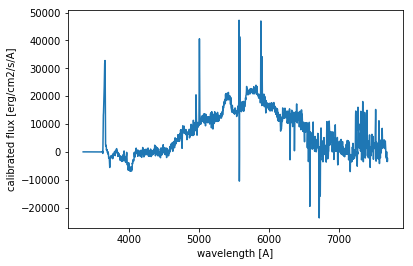

{'ObjectAreas': [[800, 957], [978, 1038], [1090, 1240], [1262, 1716]], 'SkyLeft': [404, 580], 'SkyRight': [1782, 1982], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt.fits', 'OName': 'We2-260'}


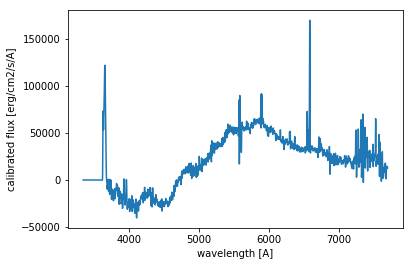

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volume

{'ObjectAreas': [[1269, 1295], [1311, 1359]], 'SkyLeft': [536, 696], 'SkyRight': [1571, 1659], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt.fits', 'OName': 'IPHASXJ225420'}


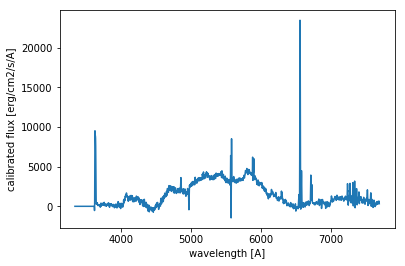

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volume

{'ObjectAreas': [[974, 1038], [1128, 1188], [1206, 1288], [1308, 1514], [1534, 1554], [1570, 1662]], 'SkyLeft': [688, 956], 'SkyRight': [1764, 1878], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt.fits', 'OName': ''}


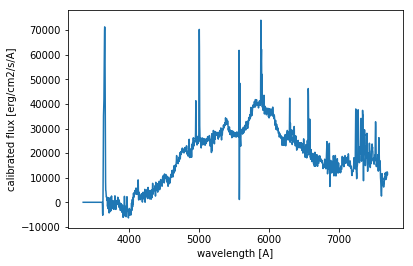

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volume

{'ObjectAreas': [[944, 998], [1012, 1038], [1090, 1110], [1138, 1150], [1168, 1220], [1254, 1270], [1284, 1354], [1382, 1412], [1440, 1460], [1486, 1510], [1542, 1552], [1572, 1586], [1602, 1610], [1626, 1652]], 'SkyLeft': [428, 534], 'SkyRight': [1836, 1916], 'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt.fits', 'OName': 'IPHASXJ193849'}


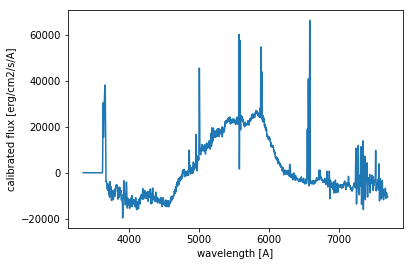

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volume

In [104]:
tab = [
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits', 'ylim' : [-30000.,50000.], 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[612,702], 'SkyRight':[1823,1855], 'ObjectAreas':[[1090,1125],[1164,1212],[1238,1252],[1267,1295],[1307,1353],[1367,1444],[1495,1516],[1530,1556],[1600,1650],[1665,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt.fits', 'ylim' : [-50000.,180000], 'OName': 'We2-260', 'SkyLeft':[404,580], 'SkyRight':[1782,1982], 'ObjectAreas':[[800,957],[978,1038],[1090,1240],[1262,1716]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt.fits', 'ylim' : [-3000.,25000.], 'OName': 'IPHASXJ225420', 'SkyLeft':[536,696], 'SkyRight':[1571,1659], 'ObjectAreas':[[1269,1295],[1311,1359]]},#line at 6559, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt.fits', 'ylim' : [-10000,79000.], 'OName': '', 'SkyLeft':[688,956], 'SkyRight':[1764,1878], 'ObjectAreas':[[974,1038],[1128,1188],[1206,1288],[1308,1514],[1534,1554],[1570,1662]]},#lines at 5005, 6560, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal.fits', 'ylim' : [,], 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt.fits', 'ylim' : [-23000.,70000.], 'OName': 'IPHASXJ193849', 'SkyLeft':[428,534], 'SkyRight':[1836,1916], 'ObjectAreas':[[944,998],[1012,1038],[1090,1110],[1138,1150],[1168,1220],[1254,1270],[1284,1354],[1382,1412],[1440,1460],[1486,1510],[1542,1552],[1572,1586],[1602,1610],[1626,1652]]},#lines at 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt.fits', 'ylim' : [,], 'OName': 'ldu18', 'SkyLeft':[1122,1170], 'SkyRight':[1388,1504], 'ObjectAreas':[[1266,1344]]},#lines at 4956, 5005
]

i=1
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    hdulist = pyfits.open(image_file)
#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    obs['OName'] = header['OBJECT']
    print obs
    if True:
        wavelength = getWavelength(header)
        image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
        imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

        obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])
        
        obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
        
        spectrum = np.ndarray(skyLeft.shape[0], dtype=np.float32)
        for iRow in range(spectrum.shape[0]):
            spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]
        
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        plt.ylabel('calibrated flux [erg/cm2/s/A]')
        plt.title(obs['OName'])
#        plt.ylim(-1.0e-15,1.0e-15)
        plt.show()
        
        # --- mark sky and object areas in original image
        markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

        hdulist[0].data = obsCols
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

        hdulist[0].data = obsColsSmoothed
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

        hdulist[0].data = image_data
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

        hdulist[0].data = imageSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

        hdulist[0].data = imageMinusSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)
        
        # --- write spectrum
        with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
            for i in range(len(wavelength)):
                f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
#        STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab

In [37]:
import pyfits
import os
execfile("/Users/azuri/entwicklung/python/myUtils.py")# import getDate, findClosestDate

stddates = []
stds = []
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    stdpath = os.path.join(image_file[0:image_file.rfind('/')],'stds')
    tempfile = '/tmp/temp.ls'
    try:
        a = os.system('ls '+stdpath+' > '+tempfile)
        with open(tempfile, 'r') as f:
            line = ''
            for lines in f:
                line = lines.strip()
            std = os.path.join(stdpath,line)
            print 'std = ',std
            hduliststd = pyfits.open(std)
            headerstd = hduliststd[0].header
            stddates.append(getDateTime(headerstd['DATE-OBS']))
            stds.append(std)
    except:
        """nothing"""

tabstd = [
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits', 'ylim' : [-30000.,50000.], 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[612,702], 'SkyRight':[1823,1855], 'ObjectAreas':[[1090,1125],[1164,1212],[1238,1252],[1267,1295],[1307,1353],[1367,1444],[1495,1516],[1530,1556],[1600,1650],[1665,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt.fits', 'ylim' : [-50000.,180000], 'OName': 'We2-260', 'SkyLeft':[404,580], 'SkyRight':[1782,1982], 'ObjectAreas':[[800,957],[978,1038],[1090,1240],[1262,1716]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt.fits', 'ylim' : [-3000.,25000.], 'OName': 'IPHASXJ225420', 'SkyLeft':[536,696], 'SkyRight':[1571,1659], 'ObjectAreas':[[1269,1295],[1311,1359]]},#line at 6559, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt.fits', 'ylim' : [-10000,79000.], 'OName': '', 'SkyLeft':[688,956], 'SkyRight':[1764,1878], 'ObjectAreas':[[974,1038],[1128,1188],[1206,1288],[1308,1514],[1534,1554],[1570,1662]]},#lines at 5005, 6560, 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt.fits', 'ylim' : [-23000.,70000.], 'OName': 'IPHASXJ193849', 'SkyLeft':[428,534], 'SkyRight':[1836,1916], 'ObjectAreas':[[944,998],[1012,1038],[1090,1110],[1138,1150],[1168,1220],[1254,1270],[1284,1354],[1382,1412],[1440,1460],[1486,1510],[1542,1552],[1572,1586],[1602,1610],[1626,1652]]},#lines at 6580
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt.fits', 'ylim' : [-10000,79000.], 'OName': 'ldu18', 'SkyLeft':[1122,1170], 'SkyRight':[1388,1504], 'ObjectAreas':[[1266,1344]]},#lines at 4956, 5005
]
for obs in tabstd:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])

    hdulist = pyfits.open(image_file)
    header = hdulist[0].header
#    try:
    if True:
        print 'obs name = ',obs['FName'],': DATE-OBS = ',header['DATE-OBS']
        obsdate = getDateTime(header['DATE-OBS'])
        closestStdDate, closestStdIdx, diffMin = findClosestInTime(obsdate, stddates)
        d = divmod(diffMin,86400)  # days
        h = divmod(d[1],3600)  # hours
        m = divmod(h[1],60)  # minutes
        s = m[1]  # seconds

        print 'closestStdDate = ',closestStdDate,', std = ',stds[closestStdIdx],', diffMin = ',diffMin,' = %d days, %d hours, %d minutes, %d seconds' % (d[0],h[0],m[0],s)
#    except:
#        """nothing"""
os.system('rm '+tempfile)


std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/stds/0001208855-20170416-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2017-04-17 05:48:10
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/stds/0001208855-20170416-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2017-04-17 05:48:10
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0003/stds/0001224617-20170517-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2017-05-18 05:25:40
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0004/stds/0001298424-20170811-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2017-08-12 05:38:35
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0005/stds/0001224617-20170517-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2017-05-18 05:25:40
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_20

time =  2017-04-05 20:45:54
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/stds/0001196975-20170405-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2017-04-05 20:45:54
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/stds/0001016384-20160827-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2016-08-28 05:58:49
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/stds/0000986629-20160717-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2016-07-18 05:29:18
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/stds/0001013763-20160819-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2016-08-20 05:44:50
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/stds/0000887657-20160524-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2016-05-25 04:55:19
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/

time =  2018-05-16 21:40:55
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/stds/0001553045-20180516-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2018-05-16 21:40:55
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/stds/0001553045-20180516-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2018-05-16 21:40:55
std =  /Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/stds/0001527787-20180428-OSIRIS-OsirisLongSlitSpectroscopy.fits
time =  2018-04-28 20:31:37
obs name =  IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits : DATE-OBS =  2016-08-21T23:21:42.667
time =  2016-08-21 23:21:42
diff =  -239 days, 17:33:32 , timediff =  <type 'float'> :  20586388.0
diff =  -239 days, 17:33:32 , timediff =  <type 'float'> :  20586388.0
diff =  -270 days, 17:56:02 , timediff =  <type 'float'> :  23263438.0
diff =  -356 days, 17:43:07 , timediff =  <type 'fl

diff =  167 days, 8:27:56 , timediff =  <type 'float'> :  14459276.0
diff =  81 days, 7:34:28 , timediff =  <type 'float'> :  7025668.0
diff =  71 days, 23:48:44 , timediff =  <type 'float'> :  6220124.0
diff =  167 days, 8:27:56 , timediff =  <type 'float'> :  14459276.0
diff =  41 days, 23:46:57 , timediff =  <type 'float'> :  3628017.0
diff =  1 day, 23:14:16 , timediff =  <type 'float'> :  170056.0
diff =  11 days, 23:30:44 , timediff =  <type 'float'> :  1035044.0
diff =  68 days, 23:44:44 , timediff =  <type 'float'> :  5960684.0
diff =  59 days, 23:36:50 , timediff =  <type 'float'> :  5182610.0
diff =  -227 days, 8:13:12 , timediff =  <type 'float'> :  19583208.0
diff =  97 days, 23:37:10 , timediff =  <type 'float'> :  8465830.0
diff =  55 days, 7:28:32 , timediff =  <type 'float'> :  4778912.0
diff =  1 day, 23:14:16 , timediff =  <type 'float'> :  170056.0
diff =  41 days, 23:46:57 , timediff =  <type 'float'> :  3628017.0
diff =  1 day, 23:14:16 , timediff =  <type 'float'>

obs name =  IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt.fits : DATE-OBS =  2016-08-22T04:04:21.192
time =  2016-08-22 04:04:21
diff =  -239 days, 22:16:11 , timediff =  <type 'float'> :  20569429.0
diff =  -239 days, 22:16:11 , timediff =  <type 'float'> :  20569429.0
diff =  -270 days, 22:38:41 , timediff =  <type 'float'> :  23246479.0
diff =  -356 days, 22:25:46 , timediff =  <type 'float'> :  30677654.0
diff =  -270 days, 22:38:41 , timediff =  <type 'float'> :  23246479.0
diff =  -238 days, 22:10:37 , timediff =  <type 'float'> :  20483363.0
diff =  -236 days, 22:11:27 , timediff =  <type 'float'> :  20310513.0
diff =  -356 days, 22:25:46 , timediff =  <type 'float'> :  30677654.0
diff =  -277 days, 0:19:34 , timediff =  <type 'float'> :  23931626.0
diff =  -227 days, 7:18:27 , timediff =  <type 'float'> :  19586493.0
diff =  -227 days, 7:18:27 , timediff =  <type 'float'> :  19586493.0
diff =  -237 days, 22:29:58 , timediff =  <type 'float'> :  20395802.0
d

0

In [54]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import ICRS, SkyCoord, EarthLocation, AltAz

image_file = '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt.fits'

hdulist = pyfits.open(image_file)
header = hdulist[0].header

ldu18 = SkyCoord(ICRS, ra=322.46798*u.deg, dec=50.90601*u.deg, obstime=header['DATE-OBS'])
#Observatorio del Roque de los Muchachos La Palma
#28.7573° N, 17.8850° W
del_Roque = EarthLocation(lat=28.7573*u.deg, lon=17.885*u.deg, height=2348*u.m)
ldu18az = ldu18.transform_to(AltAz(obstime=header['DATE-OBS'], location=del_Roque))
print 'ldu18az.secz = ',ldu18az.secz

ldu18az.secz =  1.46752602752


In [67]:
fname = '/iraf/iraf/noao/lib/onedstds/oke1990/g158100.dat'
lines = []
with open(fname,'r') as f:
    iLine = 0
    for line in f:
        line = line.split()
        print 'line = ',line
        if iLine == 0:
            lines.append(line[0]+' '+line[1])
        else:
            flux = str(float(line[1])/10.)
            print 'flux = <'+flux+'>'
            lines.append(line[0]+' '+flux+' '+line[2])
        print 'lines[',iLine,'] = <'+lines[iLine]
        iLine += 1
with open(fname,'w') as f:
    f.write("\n".join(lines))

line =  ['#', 'G158-100']
lines[ 0 ] = <# G158-100
line =  ['3200.00', '16.821', '7.0']
flux = <1.6821>
lines[ 1 ] = <3200.00 1.6821 7.0
line =  ['3201.00', '16.769', '7.0']
flux = <1.6769>
lines[ 2 ] = <3201.00 1.6769 7.0
line =  ['3202.00', '16.734', '7.0']
flux = <1.6734>
lines[ 3 ] = <3202.00 1.6734 7.0
line =  ['3203.00', '16.744', '7.0']
flux = <1.6744>
lines[ 4 ] = <3203.00 1.6744 7.0
line =  ['3204.00', '16.759', '7.0']
flux = <1.6759>
lines[ 5 ] = <3204.00 1.6759 7.0
line =  ['3205.00', '16.824', '7.0']
flux = <1.6824>
lines[ 6 ] = <3205.00 1.6824 7.0
line =  ['3206.00', '16.887', '7.0']
flux = <1.6887>
lines[ 7 ] = <3206.00 1.6887 7.0
line =  ['3207.00', '16.820', '7.0']
flux = <1.682>
lines[ 8 ] = <3207.00 1.682 7.0
line =  ['3208.00', '16.751', '7.0']
flux = <1.6751>
lines[ 9 ] = <3208.00 1.6751 7.0
line =  ['3209.00', '16.720', '7.0']
flux = <1.672>
lines[ 10 ] = <3209.00 1.672 7.0
line =  ['3210.00', '16.692', '7.0']
flux = <1.6692>
lines[ 11 ] = <3210.00 1.6692 7.0
line 

line =  ['3501.00', '16.328', '7.0']
flux = <1.6328>
lines[ 302 ] = <3501.00 1.6328 7.0
line =  ['3502.00', '16.330', '7.0']
flux = <1.633>
lines[ 303 ] = <3502.00 1.633 7.0
line =  ['3503.00', '16.330', '7.0']
flux = <1.633>
lines[ 304 ] = <3503.00 1.633 7.0
line =  ['3504.00', '16.314', '7.0']
flux = <1.6314>
lines[ 305 ] = <3504.00 1.6314 7.0
line =  ['3505.00', '16.300', '7.0']
flux = <1.63>
lines[ 306 ] = <3505.00 1.63 7.0
line =  ['3506.00', '16.300', '7.0']
flux = <1.63>
lines[ 307 ] = <3506.00 1.63 7.0
line =  ['3507.00', '16.301', '7.0']
flux = <1.6301>
lines[ 308 ] = <3507.00 1.6301 7.0
line =  ['3508.00', '16.323', '7.0']
flux = <1.6323>
lines[ 309 ] = <3508.00 1.6323 7.0
line =  ['3509.00', '16.345', '7.0']
flux = <1.6345>
lines[ 310 ] = <3509.00 1.6345 7.0
line =  ['3510.00', '16.356', '7.0']
flux = <1.6356>
lines[ 311 ] = <3510.00 1.6356 7.0
line =  ['3511.00', '16.363', '7.0']
flux = <1.6363>
lines[ 312 ] = <3511.00 1.6363 7.0
line =  ['3512.00', '16.379', '7.0']
flux = 

line =  ['3751.00', '16.179', '7.0']
flux = <1.6179>
lines[ 552 ] = <3751.00 1.6179 7.0
line =  ['3752.00', '16.161', '7.0']
flux = <1.6161>
lines[ 553 ] = <3752.00 1.6161 7.0
line =  ['3753.00', '16.150', '7.0']
flux = <1.615>
lines[ 554 ] = <3753.00 1.615 7.0
line =  ['3754.00', '16.139', '7.0']
flux = <1.6139>
lines[ 555 ] = <3754.00 1.6139 7.0
line =  ['3755.00', '16.130', '7.0']
flux = <1.613>
lines[ 556 ] = <3755.00 1.613 7.0
line =  ['3756.00', '16.120', '7.0']
flux = <1.612>
lines[ 557 ] = <3756.00 1.612 7.0
line =  ['3757.00', '16.123', '7.0']
flux = <1.6123>
lines[ 558 ] = <3757.00 1.6123 7.0
line =  ['3758.00', '16.140', '7.0']
flux = <1.614>
lines[ 559 ] = <3758.00 1.614 7.0
line =  ['3759.00', '16.148', '7.0']
flux = <1.6148>
lines[ 560 ] = <3759.00 1.6148 7.0
line =  ['3760.00', '16.136', '7.0']
flux = <1.6136>
lines[ 561 ] = <3760.00 1.6136 7.0
line =  ['3761.00', '16.123', '7.0']
flux = <1.6123>
lines[ 562 ] = <3761.00 1.6123 7.0
line =  ['3762.00', '16.110', '7.0']
flu

flux = <1.5654>
lines[ 812 ] = <4011.00 1.5654 7.0
line =  ['4012.00', '15.652', '7.0']
flux = <1.5652>
lines[ 813 ] = <4012.00 1.5652 7.0
line =  ['4013.00', '15.654', '7.0']
flux = <1.5654>
lines[ 814 ] = <4013.00 1.5654 7.0
line =  ['4014.00', '15.659', '7.0']
flux = <1.5659>
lines[ 815 ] = <4014.00 1.5659 7.0
line =  ['4015.00', '15.663', '7.0']
flux = <1.5663>
lines[ 816 ] = <4015.00 1.5663 7.0
line =  ['4016.00', '15.668', '7.0']
flux = <1.5668>
lines[ 817 ] = <4016.00 1.5668 7.0
line =  ['4017.00', '15.670', '7.0']
flux = <1.567>
lines[ 818 ] = <4017.00 1.567 7.0
line =  ['4018.00', '15.671', '7.0']
flux = <1.5671>
lines[ 819 ] = <4018.00 1.5671 7.0
line =  ['4019.00', '15.673', '7.0']
flux = <1.5673>
lines[ 820 ] = <4019.00 1.5673 7.0
line =  ['4020.00', '15.673', '7.0']
flux = <1.5673>
lines[ 821 ] = <4020.00 1.5673 7.0
line =  ['4021.00', '15.671', '7.0']
flux = <1.5671>
lines[ 822 ] = <4021.00 1.5671 7.0
line =  ['4022.00', '15.675', '7.0']
flux = <1.5675>
lines[ 823 ] = <40

flux = <1.5574>
lines[ 1084 ] = <4283.00 1.5574 7.0
line =  ['4284.00', '15.581', '7.0']
flux = <1.5581>
lines[ 1085 ] = <4284.00 1.5581 7.0
line =  ['4285.00', '15.586', '7.0']
flux = <1.5586>
lines[ 1086 ] = <4285.00 1.5586 7.0
line =  ['4286.00', '15.590', '7.0']
flux = <1.559>
lines[ 1087 ] = <4286.00 1.559 7.0
line =  ['4287.00', '15.593', '7.0']
flux = <1.5593>
lines[ 1088 ] = <4287.00 1.5593 7.0
line =  ['4288.00', '15.599', '7.0']
flux = <1.5599>
lines[ 1089 ] = <4288.00 1.5599 7.0
line =  ['4289.00', '15.605', '7.0']
flux = <1.5605>
lines[ 1090 ] = <4289.00 1.5605 7.0
line =  ['4290.00', '15.614', '7.0']
flux = <1.5614>
lines[ 1091 ] = <4290.00 1.5614 7.0
line =  ['4291.00', '15.623', '7.0']
flux = <1.5623>
lines[ 1092 ] = <4291.00 1.5623 7.0
line =  ['4292.00', '15.633', '7.0']
flux = <1.5633>
lines[ 1093 ] = <4292.00 1.5633 7.0
line =  ['4293.00', '15.647', '7.0']
flux = <1.5647>
lines[ 1094 ] = <4293.00 1.5647 7.0
line =  ['4294.00', '15.661', '7.0']
flux = <1.5661>
lines[ 

line =  ['4555.00', '15.277', '7.0']
flux = <1.5277>
lines[ 1356 ] = <4555.00 1.5277 7.0
line =  ['4556.00', '15.277', '7.0']
flux = <1.5277>
lines[ 1357 ] = <4556.00 1.5277 7.0
line =  ['4557.00', '15.276', '7.0']
flux = <1.5276>
lines[ 1358 ] = <4557.00 1.5276 7.0
line =  ['4558.00', '15.272', '7.0']
flux = <1.5272>
lines[ 1359 ] = <4558.00 1.5272 7.0
line =  ['4559.00', '15.272', '7.0']
flux = <1.5272>
lines[ 1360 ] = <4559.00 1.5272 7.0
line =  ['4560.00', '15.272', '7.0']
flux = <1.5272>
lines[ 1361 ] = <4560.00 1.5272 7.0
line =  ['4561.00', '15.274', '7.0']
flux = <1.5274>
lines[ 1362 ] = <4561.00 1.5274 7.0
line =  ['4562.00', '15.277', '7.0']
flux = <1.5277>
lines[ 1363 ] = <4562.00 1.5277 7.0
line =  ['4563.00', '15.277', '7.0']
flux = <1.5277>
lines[ 1364 ] = <4563.00 1.5277 7.0
line =  ['4564.00', '15.279', '7.0']
flux = <1.5279>
lines[ 1365 ] = <4564.00 1.5279 7.0
line =  ['4565.00', '15.281', '7.0']
flux = <1.5281>
lines[ 1366 ] = <4565.00 1.5281 7.0
line =  ['4566.00', '

lines[ 1588 ] = <4874.00 1.5109 13.0
line =  ['4876.00', '15.102', '13.0']
flux = <1.5102>
lines[ 1589 ] = <4876.00 1.5102 13.0
line =  ['4878.00', '15.095', '13.0']
flux = <1.5095>
lines[ 1590 ] = <4878.00 1.5095 13.0
line =  ['4880.00', '15.088', '13.0']
flux = <1.5088>
lines[ 1591 ] = <4880.00 1.5088 13.0
line =  ['4882.00', '15.088', '13.0']
flux = <1.5088>
lines[ 1592 ] = <4882.00 1.5088 13.0
line =  ['4884.00', '15.088', '13.0']
flux = <1.5088>
lines[ 1593 ] = <4884.00 1.5088 13.0
line =  ['4886.00', '15.090', '13.0']
flux = <1.509>
lines[ 1594 ] = <4886.00 1.509 13.0
line =  ['4888.00', '15.090', '13.0']
flux = <1.509>
lines[ 1595 ] = <4888.00 1.509 13.0
line =  ['4890.00', '15.093', '13.0']
flux = <1.5093>
lines[ 1596 ] = <4890.00 1.5093 13.0
line =  ['4892.00', '15.093', '13.0']
flux = <1.5093>
lines[ 1597 ] = <4892.00 1.5093 13.0
line =  ['4894.00', '15.095', '13.0']
flux = <1.5095>
lines[ 1598 ] = <4894.00 1.5095 13.0
line =  ['4896.00', '15.095', '13.0']
flux = <1.5095>
lin

flux = <1.4897>
lines[ 1858 ] = <5414.00 1.4897 13.0
line =  ['5416.00', '14.897', '13.0']
flux = <1.4897>
lines[ 1859 ] = <5416.00 1.4897 13.0
line =  ['5418.00', '14.897', '13.0']
flux = <1.4897>
lines[ 1860 ] = <5418.00 1.4897 13.0
line =  ['5420.00', '14.897', '13.0']
flux = <1.4897>
lines[ 1861 ] = <5420.00 1.4897 13.0
line =  ['5422.00', '14.897', '13.0']
flux = <1.4897>
lines[ 1862 ] = <5422.00 1.4897 13.0
line =  ['5424.00', '14.897', '13.0']
flux = <1.4897>
lines[ 1863 ] = <5424.00 1.4897 13.0
line =  ['5426.00', '14.897', '13.0']
flux = <1.4897>
lines[ 1864 ] = <5426.00 1.4897 13.0
line =  ['5428.00', '14.895', '13.0']
flux = <1.4895>
lines[ 1865 ] = <5428.00 1.4895 13.0
line =  ['5430.00', '14.895', '13.0']
flux = <1.4895>
lines[ 1866 ] = <5430.00 1.4895 13.0
line =  ['5432.00', '14.895', '13.0']
flux = <1.4895>
lines[ 1867 ] = <5432.00 1.4895 13.0
line =  ['5434.00', '14.894', '13.0']
flux = <1.4894>
lines[ 1868 ] = <5434.00 1.4894 13.0
line =  ['5436.00', '14.894', '13.0']

lines[ 2086 ] = <5870.00 1.4769 13.0
line =  ['5872.00', '14.769', '13.0']
flux = <1.4769>
lines[ 2087 ] = <5872.00 1.4769 13.0
line =  ['5874.00', '14.769', '13.0']
flux = <1.4769>
lines[ 2088 ] = <5874.00 1.4769 13.0
line =  ['5876.00', '14.769', '13.0']
flux = <1.4769>
lines[ 2089 ] = <5876.00 1.4769 13.0
line =  ['5878.00', '14.769', '13.0']
flux = <1.4769>
lines[ 2090 ] = <5878.00 1.4769 13.0
line =  ['5880.00', '14.767', '13.0']
flux = <1.4767>
lines[ 2091 ] = <5880.00 1.4767 13.0
line =  ['5882.00', '14.767', '13.0']
flux = <1.4767>
lines[ 2092 ] = <5882.00 1.4767 13.0
line =  ['5884.00', '14.767', '13.0']
flux = <1.4767>
lines[ 2093 ] = <5884.00 1.4767 13.0
line =  ['5886.00', '14.767', '13.0']
flux = <1.4767>
lines[ 2094 ] = <5886.00 1.4767 13.0
line =  ['5888.00', '14.767', '13.0']
flux = <1.4767>
lines[ 2095 ] = <5888.00 1.4767 13.0
line =  ['5890.00', '14.767', '13.0']
flux = <1.4767>
lines[ 2096 ] = <5890.00 1.4767 13.0
line =  ['5892.00', '14.765', '13.0']
flux = <1.4765>

line =  ['6388.00', '14.642', '13.0']
flux = <1.4642>
lines[ 2345 ] = <6388.00 1.4642 13.0
line =  ['6390.00', '14.640', '13.0']
flux = <1.464>
lines[ 2346 ] = <6390.00 1.464 13.0
line =  ['6392.00', '14.640', '13.0']
flux = <1.464>
lines[ 2347 ] = <6392.00 1.464 13.0
line =  ['6394.00', '14.640', '13.0']
flux = <1.464>
lines[ 2348 ] = <6394.00 1.464 13.0
line =  ['6396.00', '14.637', '13.0']
flux = <1.4637>
lines[ 2349 ] = <6396.00 1.4637 13.0
line =  ['6398.00', '14.637', '13.0']
flux = <1.4637>
lines[ 2350 ] = <6398.00 1.4637 13.0
line =  ['6400.00', '14.635', '13.0']
flux = <1.4635>
lines[ 2351 ] = <6400.00 1.4635 13.0
line =  ['6402.00', '14.635', '13.0']
flux = <1.4635>
lines[ 2352 ] = <6402.00 1.4635 13.0
line =  ['6404.00', '14.633', '13.0']
flux = <1.4633>
lines[ 2353 ] = <6404.00 1.4633 13.0
line =  ['6406.00', '14.633', '13.0']
flux = <1.4633>
lines[ 2354 ] = <6406.00 1.4633 13.0
line =  ['6408.00', '14.633', '13.0']
flux = <1.4633>
lines[ 2355 ] = <6408.00 1.4633 13.0
line 

flux = <1.4549>
lines[ 2614 ] = <6926.00 1.4549 13.0
line =  ['6928.00', '14.549', '13.0']
flux = <1.4549>
lines[ 2615 ] = <6928.00 1.4549 13.0
line =  ['6930.00', '14.549', '13.0']
flux = <1.4549>
lines[ 2616 ] = <6930.00 1.4549 13.0
line =  ['6932.00', '14.549', '13.0']
flux = <1.4549>
lines[ 2617 ] = <6932.00 1.4549 13.0
line =  ['6934.00', '14.549', '13.0']
flux = <1.4549>
lines[ 2618 ] = <6934.00 1.4549 13.0
line =  ['6936.00', '14.549', '13.0']
flux = <1.4549>
lines[ 2619 ] = <6936.00 1.4549 13.0
line =  ['6938.00', '14.548', '13.0']
flux = <1.4548>
lines[ 2620 ] = <6938.00 1.4548 13.0
line =  ['6940.00', '14.548', '13.0']
flux = <1.4548>
lines[ 2621 ] = <6940.00 1.4548 13.0
line =  ['6942.00', '14.548', '13.0']
flux = <1.4548>
lines[ 2622 ] = <6942.00 1.4548 13.0
line =  ['6944.00', '14.548', '13.0']
flux = <1.4548>
lines[ 2623 ] = <6944.00 1.4548 13.0
line =  ['6946.00', '14.548', '13.0']
flux = <1.4548>
lines[ 2624 ] = <6946.00 1.4548 13.0
line =  ['6948.00', '14.548', '13.0']

line =  ['7442.00', '14.475', '13.0']
flux = <1.4475>
lines[ 2872 ] = <7442.00 1.4475 13.0
line =  ['7444.00', '14.475', '13.0']
flux = <1.4475>
lines[ 2873 ] = <7444.00 1.4475 13.0
line =  ['7446.00', '14.474', '13.0']
flux = <1.4474>
lines[ 2874 ] = <7446.00 1.4474 13.0
line =  ['7448.00', '14.472', '13.0']
flux = <1.4472>
lines[ 2875 ] = <7448.00 1.4472 13.0
line =  ['7450.00', '14.472', '13.0']
flux = <1.4472>
lines[ 2876 ] = <7450.00 1.4472 13.0
line =  ['7452.00', '14.470', '13.0']
flux = <1.447>
lines[ 2877 ] = <7452.00 1.447 13.0
line =  ['7454.00', '14.470', '13.0']
flux = <1.447>
lines[ 2878 ] = <7454.00 1.447 13.0
line =  ['7456.00', '14.468', '13.0']
flux = <1.4468>
lines[ 2879 ] = <7456.00 1.4468 13.0
line =  ['7458.00', '14.468', '13.0']
flux = <1.4468>
lines[ 2880 ] = <7458.00 1.4468 13.0
line =  ['7460.00', '14.468', '13.0']
flux = <1.4468>
lines[ 2881 ] = <7460.00 1.4468 13.0
line =  ['7462.00', '14.468', '13.0']
flux = <1.4468>
lines[ 2882 ] = <7462.00 1.4468 13.0
lin

lines[ 3127 ] = <7952.00 1.443 13.0
line =  ['7954.00', '14.430', '13.0']
flux = <1.443>
lines[ 3128 ] = <7954.00 1.443 13.0
line =  ['7956.00', '14.430', '13.0']
flux = <1.443>
lines[ 3129 ] = <7956.00 1.443 13.0
line =  ['7958.00', '14.430', '13.0']
flux = <1.443>
lines[ 3130 ] = <7958.00 1.443 13.0
line =  ['7960.00', '14.430', '13.0']
flux = <1.443>
lines[ 3131 ] = <7960.00 1.443 13.0
line =  ['7962.00', '14.430', '13.0']
flux = <1.443>
lines[ 3132 ] = <7962.00 1.443 13.0
line =  ['7964.00', '14.432', '13.0']
flux = <1.4432>
lines[ 3133 ] = <7964.00 1.4432 13.0
line =  ['7966.00', '14.432', '13.0']
flux = <1.4432>
lines[ 3134 ] = <7966.00 1.4432 13.0
line =  ['7968.00', '14.432', '13.0']
flux = <1.4432>
lines[ 3135 ] = <7968.00 1.4432 13.0
line =  ['7970.00', '14.432', '13.0']
flux = <1.4432>
lines[ 3136 ] = <7970.00 1.4432 13.0
line =  ['7972.00', '14.434', '13.0']
flux = <1.4434>
lines[ 3137 ] = <7972.00 1.4434 13.0
line =  ['7974.00', '14.434', '13.0']
flux = <1.4434>
lines[ 313

lines[ 3401 ] = <8500.00 1.4404 13.0
line =  ['8502.00', '14.404', '13.0']
flux = <1.4404>
lines[ 3402 ] = <8502.00 1.4404 13.0
line =  ['8504.00', '14.406', '13.0']
flux = <1.4406>
lines[ 3403 ] = <8504.00 1.4406 13.0
line =  ['8506.00', '14.408', '13.0']
flux = <1.4408>
lines[ 3404 ] = <8506.00 1.4408 13.0
line =  ['8508.00', '14.409', '13.0']
flux = <1.4409>
lines[ 3405 ] = <8508.00 1.4409 13.0
line =  ['8510.00', '14.409', '13.0']
flux = <1.4409>
lines[ 3406 ] = <8510.00 1.4409 13.0
line =  ['8512.00', '14.411', '13.0']
flux = <1.4411>
lines[ 3407 ] = <8512.00 1.4411 13.0
line =  ['8514.00', '14.411', '13.0']
flux = <1.4411>
lines[ 3408 ] = <8514.00 1.4411 13.0
line =  ['8516.00', '14.411', '13.0']
flux = <1.4411>
lines[ 3409 ] = <8516.00 1.4411 13.0
line =  ['8518.00', '14.411', '13.0']
flux = <1.4411>
lines[ 3410 ] = <8518.00 1.4411 13.0
line =  ['8520.00', '14.411', '13.0']
flux = <1.4411>
lines[ 3411 ] = <8520.00 1.4411 13.0
line =  ['8522.00', '14.411', '13.0']
flux = <1.4411>

line =  ['9030.00', '14.383', '13.0']
flux = <1.4383>
lines[ 3666 ] = <9030.00 1.4383 13.0
line =  ['9032.00', '14.385', '13.0']
flux = <1.4385>
lines[ 3667 ] = <9032.00 1.4385 13.0
line =  ['9034.00', '14.387', '13.0']
flux = <1.4387>
lines[ 3668 ] = <9034.00 1.4387 13.0
line =  ['9036.00', '14.390', '13.0']
flux = <1.439>
lines[ 3669 ] = <9036.00 1.439 13.0
line =  ['9038.00', '14.392', '13.0']
flux = <1.4392>
lines[ 3670 ] = <9038.00 1.4392 13.0
line =  ['9040.00', '14.397', '13.0']
flux = <1.4397>
lines[ 3671 ] = <9040.00 1.4397 13.0
line =  ['9042.00', '14.401', '13.0']
flux = <1.4401>
lines[ 3672 ] = <9042.00 1.4401 13.0
line =  ['9044.00', '14.404', '13.0']
flux = <1.4404>
lines[ 3673 ] = <9044.00 1.4404 13.0
line =  ['9046.00', '14.409', '13.0']
flux = <1.4409>
lines[ 3674 ] = <9046.00 1.4409 13.0
line =  ['9048.00', '14.415', '13.0']
flux = <1.4415>
lines[ 3675 ] = <9048.00 1.4415 13.0
line =  ['9050.00', '14.420', '13.0']
flux = <1.442>
lines[ 3676 ] = <9050.00 1.442 13.0
lin

In [76]:
from pyraf import iraf

def copyHeader(imFrom, imTo):
    hdulistFrom = pyfits.open(imFrom)
    headerFrom = hdulist[0].headerFrom
    
    hdulistTo = pyfits.open(imTo)
    hdulistTo[0].header = headerFrom
    hdulistTo.writeto(imTo, clobber=True)
    
def swapHeaders(imA, imB):
    hdulistA = pyfits.open(imA)
    headerA = hdulistA[0].header
    hdulistB = pyfits.open(imB)
    headerB = hdulistB[0].header
    hdulistA[0].header = headerB
    hdulistB[0].header = headerA
    hdulistA.writeto(imA, clobber=True)
    hdulistB.writeto(imB, clobber=True)

imA = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt.fits"
imB = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits"

#iraf.imcopy(imA, imA[0:imA.find('.')]+'_temp.fits')
#iraf.imcopy(imB, imB[0:imB.find('.')]+'_temp.fits')

swapHeaders(imA, imB)

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


In [79]:
def compareHeaders(imA, imB):
    hdulistA = pyfits.open(imA)
    headerA = hdulistA[0].header
    hdulistB = pyfits.open(imB)
    headerB = hdulistB[0].header
    for key in headerA.keys():
        print 'headerA[',key,'] = ',headerA[key],', headerB[',key,'] = ',headerB[key]

imA = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt.fits"
imB = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt.fits"
compareHeaders(imA, imB)

imB = "/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_temp.fits"
compareHeaders(imA, imB)


headerA[ SIMPLE ] =  True , headerB[ SIMPLE ] =  True
headerA[ BITPIX ] =  -32 , headerB[ BITPIX ] =  -32
headerA[ NAXIS ] =  2 , headerB[ NAXIS ] =  2
headerA[ NAXIS1 ] =  2110 , headerB[ NAXIS1 ] =  2110
headerA[ NAXIS2 ] =  2051 , headerB[ NAXIS2 ] =  2051
headerA[ EXTEND ] =  True , headerB[ EXTEND ] =  True
headerA[ ORIGIN ] =  NOAO-IRAF FITS Image Kernel July 2003 , headerB[ ORIGIN ] =  NOAO-IRAF FITS Image Kernel July 2003
headerA[ OBJECT ] =  IPHASXJ190333_Green_Slit , headerB[ OBJECT ] =  Kn24
headerA[ IRAF-TLM ] =  2018-08-29T08:00:46 , headerB[ IRAF-TLM ] =  2018-08-16T20:42:35
headerA[ COMMENT ] =    FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
= '-------------'      / End of engineering parameters
= 'Start Software Enginnering parameters' , headerB[ COMMENT ] =    FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; 

headerA[ DEEP ] =  2 , headerB[ DEEP ] =  2
headerA[ FRAMESI ] =  8606008 , headerB[ FRAMESI ] =  8606008
headerA[ MOSAIC ] =  true , headerB[ MOSAIC ] =  true
headerA[ PRESCAN ] =  true , headerB[ PRESCAN ] =  true
headerA[ SIMULATE ] =  false , headerB[ SIMULATE ] =  false
headerA[ SIMVAL ] =  0 , headerB[ SIMVAL ] =  0
headerA[ SIMTYPE ] =  0 , headerB[ SIMTYPE ] =  0
headerA[ APPLYPRE ] =  true , headerB[ APPLYPRE ] =  true
headerA[ OPENTIME ] =  23:21:42.667 , headerB[ OPENTIME ] =  04:41:29.048
headerA[ CLOSTIME ] =  23:41:43.143 , headerB[ CLOSTIME ] =  04:58:09.511
headerA[ ELAPSHUT ] =  1200.476 , headerB[ ELAPSHUT ] =  1000.463
headerA[ READTIME ] =  23:41:43.160 , headerB[ READTIME ] =  04:58:09.545
headerA[ IPA ] =  204.540346 , headerB[ IPA ] =  184.60344103
headerA[ IPA0 ] =  150.53 , headerB[ IPA0 ] =  150.53
headerA[ PA ] =  54.010346 , headerB[ PA ] =  34.0734410299
headerA[ AIRMASS ] =  1.10993839795 , headerB[ AIRMASS ] =  1.01759902193
headerA[ RA ] =  19:03:37.831 

In [98]:
import astropy.units as u
from astropy.coordinates import SkyCoord, FK5

gc = SkyCoord(ra=23.903139, dec=74.926083, unit='deg', frame=FK5, equinox='J2000.0')
gc.fk5
gc.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (23.90311007, 74.92608293)>

airmass =  1.300327
{'SkyLeft': [1114, 1156], 'ObjectAreas': [[1262, 1330], [1157, 1240]], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'SkyRight': [1351, 1418], 'ylim': [0, 0], 'OName': 'IPHASXJ194645'}


/Users/azuri/anaconda/envs/python2env/lib/python2.7/site-packages/ipykernel_launcher.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


nCols =  151


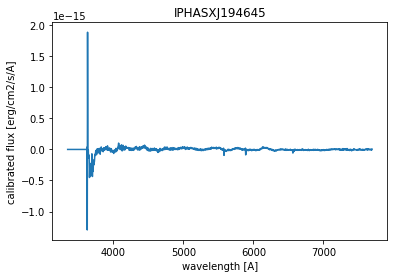

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal_obsCols.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal_obsColsSmoothed.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal_areasMarked.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting e

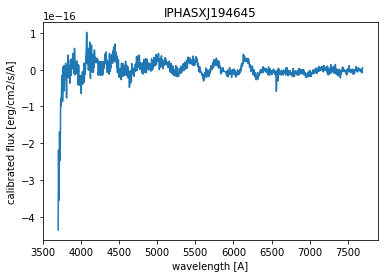

/Users/azuri/.local/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file '/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHASXJ194645_GT170417.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


time =  2017-04-17 04:07:02
datestr = <170417>


In [3]:

tab = [
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [0,0], 'OName': 'IPHASXJ194645', 'SkyLeft':[1114,1156], 'SkyRight':[1351,1418], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
#{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_x_wl_flt_cal.fits', 'ylim' : [-0.15e-15,0.3e-15], 'OName': 'IPHASXJ194645', 'SkyLeft':[835,960], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1291,1303], 'SkyRight':[1359,1380], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
##{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'ylim' : [-0.3e-15,0.8e-15], 'OName': 'IPHASXJ214032', 'SkyLeft':[1090,1250], 'SkyRight':[1552,1661], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
]
i=1
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    hdulist = pyfits.open(image_file)
#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    if header['OBJECT'] != '':
        obs['OName'] = header['OBJECT']
    try:
        print 'airmass = ',header['AIRMASS']
    except:
        """do nothing"""
    print obs
    if True:
        wavelength = getWavelength(header)
        image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
        imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

        obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])
        
        obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
        
        spectrum = np.ndarray(imageSky.shape[0], dtype=np.float32)
        for iRow in range(spectrum.shape[0]):
            spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]
        
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
        plt.show()
        
        # --- mark sky and object areas in original image
        markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

        hdulist[0].data = obsCols
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

        hdulist[0].data = obsColsSmoothed
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

        hdulist[0].data = image_data
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

        hdulist[0].data = imageSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

        hdulist[0].data = imageMinusSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        markAreas(hdulist[0].data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)
        
        # --- cut off blue end
        idx = findFirstIdxWithValGT(wavelength, 3700.)
        wavelength = wavelength[idx:]
        spectrum = spectrum[idx:]
#        print 'wavelength.shape = ',wavelength.shape
#        print 'spectrum.shape = ',spectrum.shape
        
        # --- interpolate over 5567-5590 (5577 OII sky line)
        idxL = findFirstIdxWithValGT(wavelength, 5567.)
        idxH = findFirstIdxWithValGT(wavelength, 5590.)
        spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])
        
        # --- interpolate over 5567-5590 (5577 OII sky line)
        idxL = findFirstIdxWithValGT(wavelength, 5867.)
        idxH = findFirstIdxWithValGT(wavelength, 5905.)
        spectrum, linRegPars = subtractSky(spectrum,[idxL-5,idxL],[idxH,idxH+5])
        
        # --- plot cleaned spectrum
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        yLabel = 'calibrated flux [erg/cm2/s/A]'
        if obs['FName'].find("_cal") < 0:
            print '"_cal" not found in obs["FName"] = <',obs['FName'],'> => Setting uLabel to counts [ADU]'
            yLabel = 'counts [ADU]'
        plt.ylabel(yLabel)
        if obs['ylim'][1] > 0:
            plt.ylim(obs['ylim'][0],obs['ylim'][1])
        plt.title(obs['OName'])
        plt.savefig(image_file[0:image_file.rfind('.')]+'_spectrum.png')
        plt.show()

        # --- write spectrum
        hdulist[0].data = spectrum
#        hdulist[0].header['NAXIS1'] = header['NAXIS2']
        hdulist[0].header['CRPIX1'] = header['CRPIX2']
        hdulist[0].header['CRVAL1'] = wavelength[0]
        hdulist[0].header['CDELT1'] = header['CDELT2']
        hdulist[0].header['CD1_1'] = header['CD2_2']
        hdulist[0].header['WAT1_001'] = header['WAT2_001']
#        hdulist[0].header[''] = header['']
        obsdate = getDateTime(header['DATE-OBS'])
        datestr = obsdate.strftime('%d%m%y')
        print 'datestr = <'+datestr+'>'
        specOutName = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['OName']+'_GT'+datestr+'.fits')

        hdulist.writeto(specOutName, clobber=True)

        with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
            for i in range(len(wavelength)):
                f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
#        STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab

In [ ]:
%matplotlib inline
wavelength = []
spectrum = []
with open('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal_spec.dat','r') as f:
    for lines in f:
        line = lines.split()
        wavelength.append(float(line[0]))
        spectrum.append(float(line[1]))
plt.plot(wavelength,spectrum)
plt.xlabel('wavelength [A]')
plt.ylabel('calibrated flux [erg/cm2/s/A]')
plt.xlim(6472.0, 7178.0)
plt.ylim(-0.1e-15, 1.0e-15)
plt.show()